In [1]:
!rm -rf img/ && mkdir -p img

In [2]:
import time

import figtools as ftl
import matplotlib.pyplot as plt

import numpy as np

import torch
import torch.optim

In [3]:
from helper.data import DataLoader
from helper.ukf import SimpleUKFRNN

In [4]:
torch.manual_seed(0)
assert torch.all(torch.randint(10, (10,)) == torch.tensor([4, 9, 3, 0, 3, 9, 7, 3, 7, 3]))

In [5]:
data_loader = DataLoader(phi=torch.tensor([0., np.pi / 2., np.pi, 3. / 2. * np.pi]),
                         v0=torch.tensor([1., 2., 3., 4.]),
                         n=30,
                         n_repeat=7)
X, _ = data_loader(window_size=100, randomize=True)
X.shape

torch.Size([4, 2, 111, 100])

In [6]:
def init_state(X):
    b, _, n = X.shape
    assert n >= 2
    
    x1, x2 = X[:, 0, 0], X[:, 0, 1]
    y1, y2 = X[:, 1, 0], X[:, 1, 1]
    dx = x2 - x1
    dy = y2 - y1
    
    state = torch.zeros(b, 4)
    state[:, 0] = x1 - dx # x
    state[:, 1] = y1 - dy # y
    state[:, 2] = dx # vx
    state[:, 3] = dy # vy
    
    return state

In [7]:
def train_window(X, *, f, optimizer, state_cov, process_noise, measurement_noise):
    b, _, _ = X.shape
    
    def _avg(x, idxs):
        avg = torch.sum(x[:, idxs], dim=1) / 2.
        for i in idxs:
            x[:, i] = avg
            
    def _reinit_nans(x):
        sel = ~torch.isfinite(x)
        x[sel] = torch.rand((1,))
        return torch.sum(sel)
    
    f.cell.process_noise.data = process_noise
    f.cell.measurement_noise.data = measurement_noise

    optimizer.zero_grad()

    Y, state, state_covs = f(X, init_state(X), state_cov)
    loss = torch.sum((X - Y)**2, dim=(1, 2))
    loss.backward(torch.ones(b))
   
    for k, v in f.named_parameters():
        if k == 'cell.process_noise':
            _avg(v.grad, (0, 2))
            _avg(v.grad, (5, 9))
            v.grad[:, (1, 3, 4, 6, 7, 8)] = 0.
        elif k == 'cell.measurement_noise':
            _avg(v.grad, (0, 2))
            v.grad[:, 1] = 0.

    optimizer.step()
    
    n = _reinit_nans(f.cell.process_noise.data)
    if n > 0:
        print(f'Warning! NaN values in process noise')
    
    n = _reinit_nans(f.cell.measurement_noise.data)
    if n > 0:
        print(f'Warning! NaN values in measurement noise')
    
    return {
        'process_noise': f.cell.process_noise.detach(),
        'measurement_noise': f.cell.measurement_noise.detach(),
        'state_cov': state_covs[:, :, :, -1].detach(),
        'loss': loss.tolist(),
    }


def train_epoch(X, w_max=None, **kwargs):
    b, _, w, _ = X.shape
    if w_max:
        w = min(w, w_max)
    
    losses = []
    state_cov = torch.eye(4).repeat(b, 1, 1)
    
    rnd = torch.rand(b, 2)
    process_noise = torch.zeros(b, 10)
    process_noise[:, 0] = rnd[:, 0]
    process_noise[:, 2] = rnd[:, 0]
    process_noise[:, 5] = rnd[:, 1]
    process_noise[:, 9] = rnd[:, 1]
    
    rnd = torch.rand(b, 1)
    measurement_noise = torch.zeros(b, 3)
    measurement_noise[:, 0] = rnd[:, 0]
    measurement_noise[:, 2] = rnd[:, 0]
    
    stats = None
    for i in range(w):
        stats = train_window(X[:, :, i],
                             state_cov=state_cov,
                             process_noise=process_noise,
                             measurement_noise=measurement_noise,
                             **kwargs)
        
        process_noise = stats['process_noise']
        measurement_noise = stats['measurement_noise']
        state_cov = stats['state_cov']
        losses.append(stats['loss'])
    
    return losses, stats


def train(n_epochs, w_max=None, verbose=False):
    ukf = SimpleUKFRNN(batch_size=4)
    ukf = torch.jit.script(ukf)

    optimizer = torch.optim.SGD(ukf.parameters(), lr=1e-4)
    for i in range(n_epochs):
        t_start = time.time()
        loss, stats = train_epoch(X, w_max=w_max, f=ukf, optimizer=optimizer)
        t_end = time.time()

        if verbose:
            print(f'Epoch #{i+1}:', f'(elapsed time: {(t_end-t_start):.2f}s)')    
            print(np.array(loss))
    
    return stats

In [8]:
stats = train(1, verbose=True)
state_cov = stats['state_cov']
process_noise = stats['process_noise']
measurement_noise = stats['measurement_noise']

Epoch #1: (elapsed time: 16.22s)
[[  44.88830566  122.25004578  748.24884033 1572.88183594]
 [  45.06970596  122.19608307  405.93484497  796.96173096]
 [  44.88358688  122.14357758  362.42776489  716.41125488]
 [  43.22971344  121.8835907   328.70443726  646.07922363]
 [  44.54008484  122.04885101  318.31011963  630.93579102]
 [  44.03578949  122.00097656  304.56182861  601.37365723]
 [  44.19948578  121.95597839  294.82983398  580.30175781]
 [  44.03199005  121.91197968  287.80975342  562.67358398]
 [  39.48061752  109.68252563  254.54586792  493.7442627 ]
 [  43.66148376  121.83258057  279.63482666  538.35125732]
 [  42.2075386   121.61347961  276.36636353  524.07757568]
 [  39.08260345  109.58226013  247.89019775  469.87393188]
 [  38.95882416  109.55204773  246.80535889  464.70718384]
 [  43.14228439  121.69185638  273.33520508  511.54653931]
 [  38.7048378   109.49112701  245.33912659  456.39498901]
 [  41.58673477  121.46353912  271.89868164  501.41802979]
 [  42.73787308  121.59

In [9]:
from ukf import UKFCell

print('Process noise:')
print(UKFCell.tril_square(process_noise, 4))

print('')

print('Measurement noise:')
print(UKFCell.tril_square(measurement_noise, 2))

Process noise:
tensor([[[3.7551e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 3.7551e-01, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 4.6106e-01, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 4.6106e-01]],

        [[3.7247e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 3.7247e-02, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 5.7829e-01, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 5.7829e-01]],

        [[1.2596e-04, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 1.2596e-04, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 2.3831e-01, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 2.3831e-01]],

        [[2.2150e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 2.2150e-02, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 6.5238e-01, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 6.5238e-01]]])

Measurement noise:
tensor([[[3.5

In [10]:
def evaluate(X, *, state_cov, process_noise, measurement_noise):
    b, _, _ = X.shape
    
    with torch.no_grad():
        ukf = SimpleUKFRNN(batch_size=4)
        ukf.cell.process_noise.data = process_noise
        ukf.cell.measurement_noise.data = measurement_noise
        ukf = torch.jit.script(ukf)
        
        y, _, _ = ukf(X, init_state(X), state_cov)
    
    return y

In [11]:
X_pred = evaluate(X[:, :, -1], state_cov=state_cov, process_noise=process_noise, measurement_noise=measurement_noise)
torch.sum((X[:, :, -1] - X_pred)**2, dim=(1, 2))

tensor([ 35.7740, 120.4582, 270.0094, 480.4993])

In [12]:
X_pred.shape, X.shape

(torch.Size([4, 2, 100]), torch.Size([4, 2, 111, 100]))

[Download pred_b1_train.png],[Download pred_b2_train.png],[Download pred_b3_train.png],[Download pred_b4_train.png]

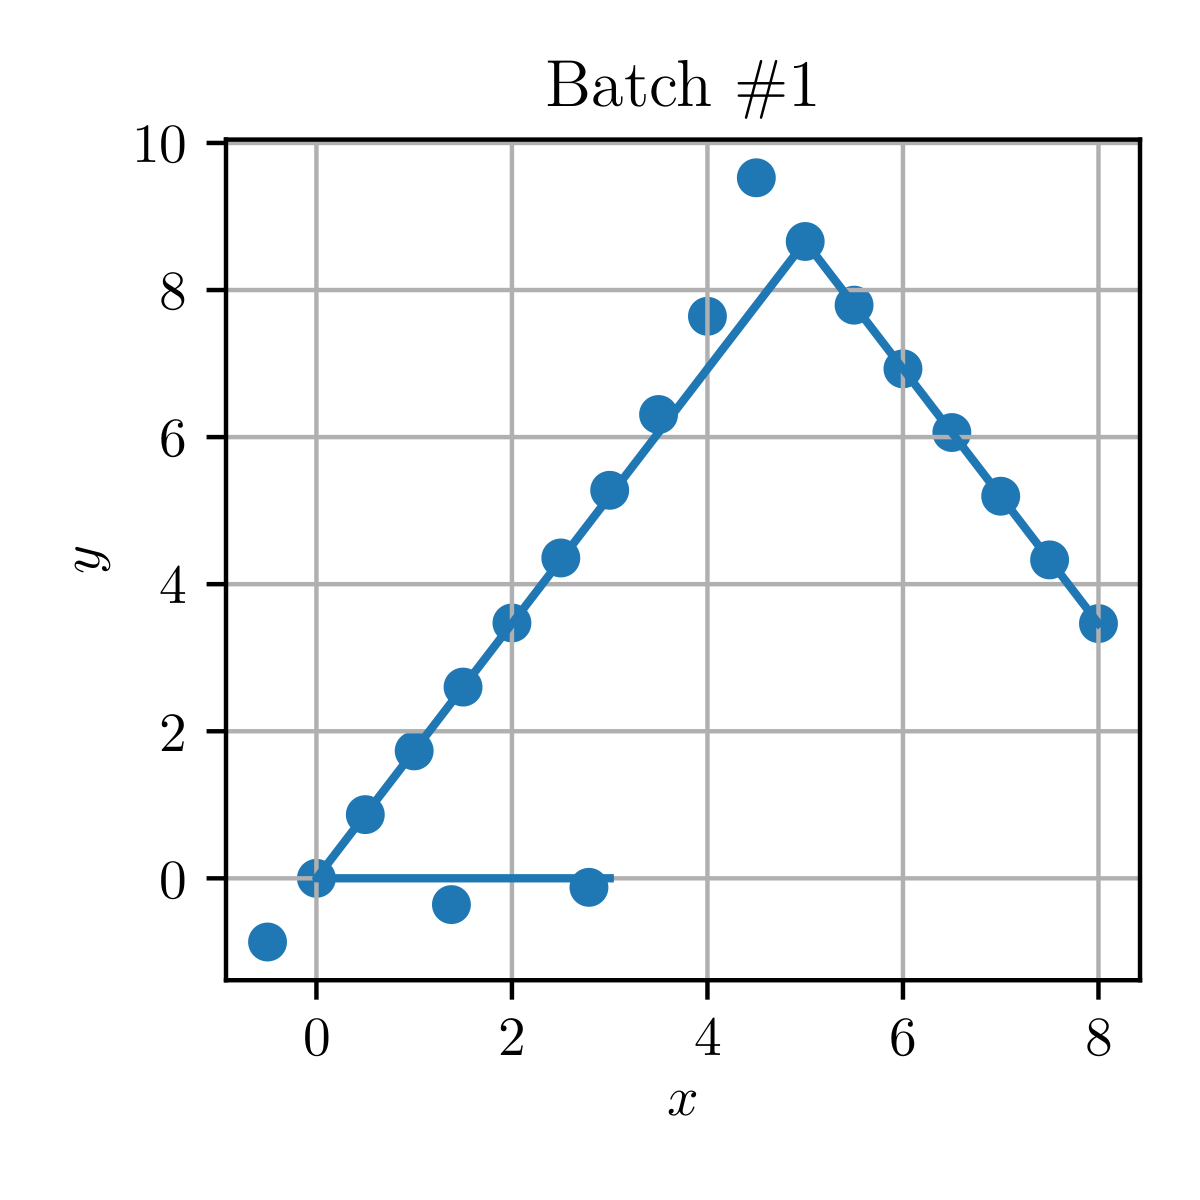
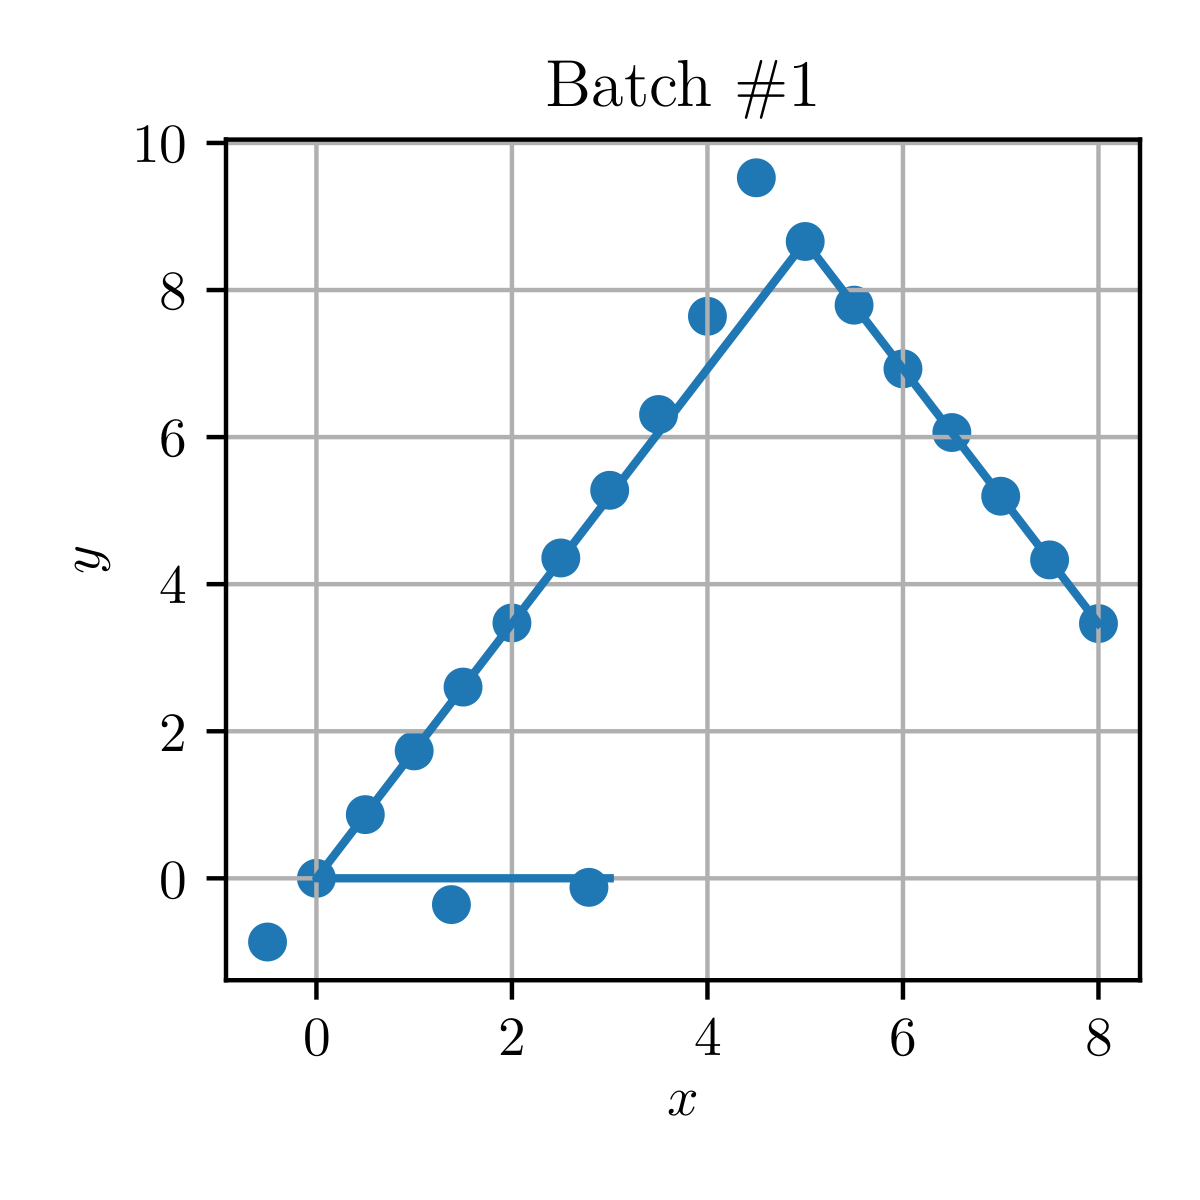
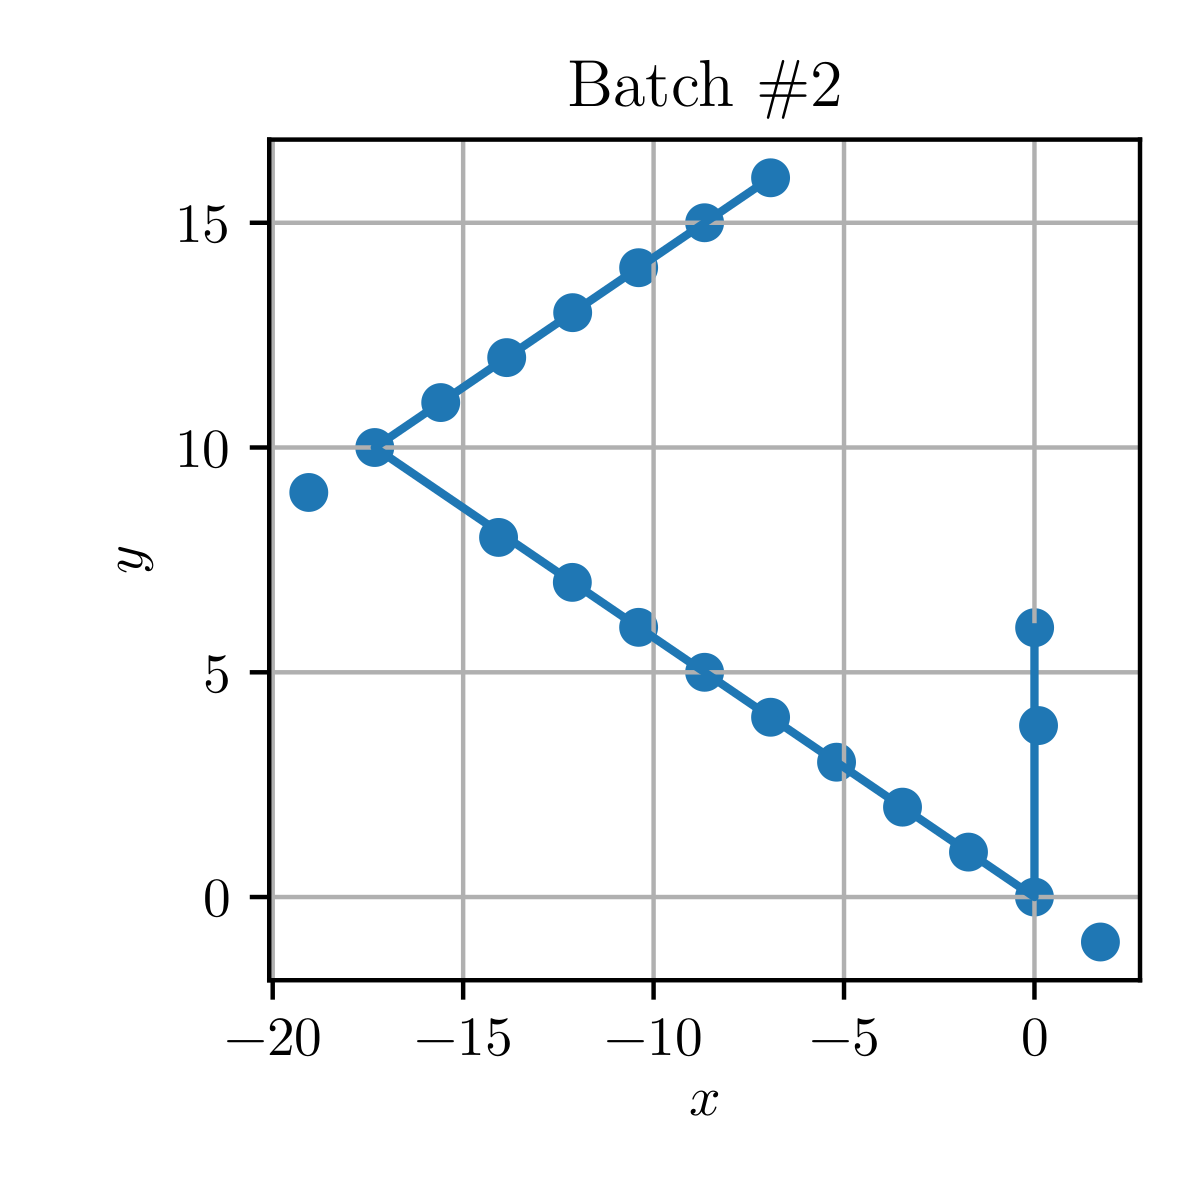
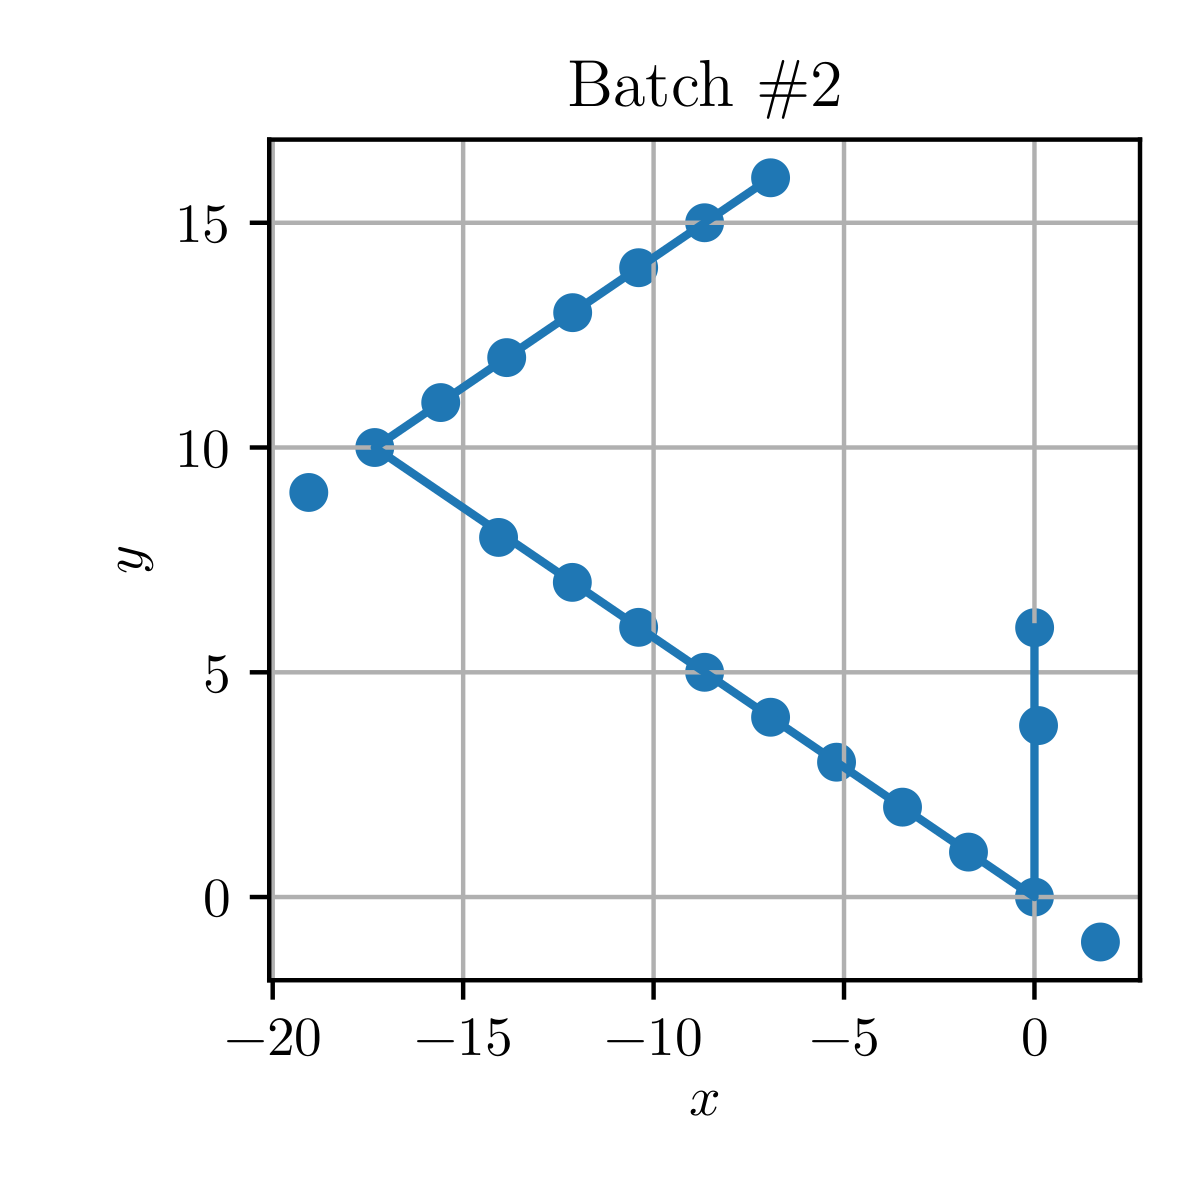
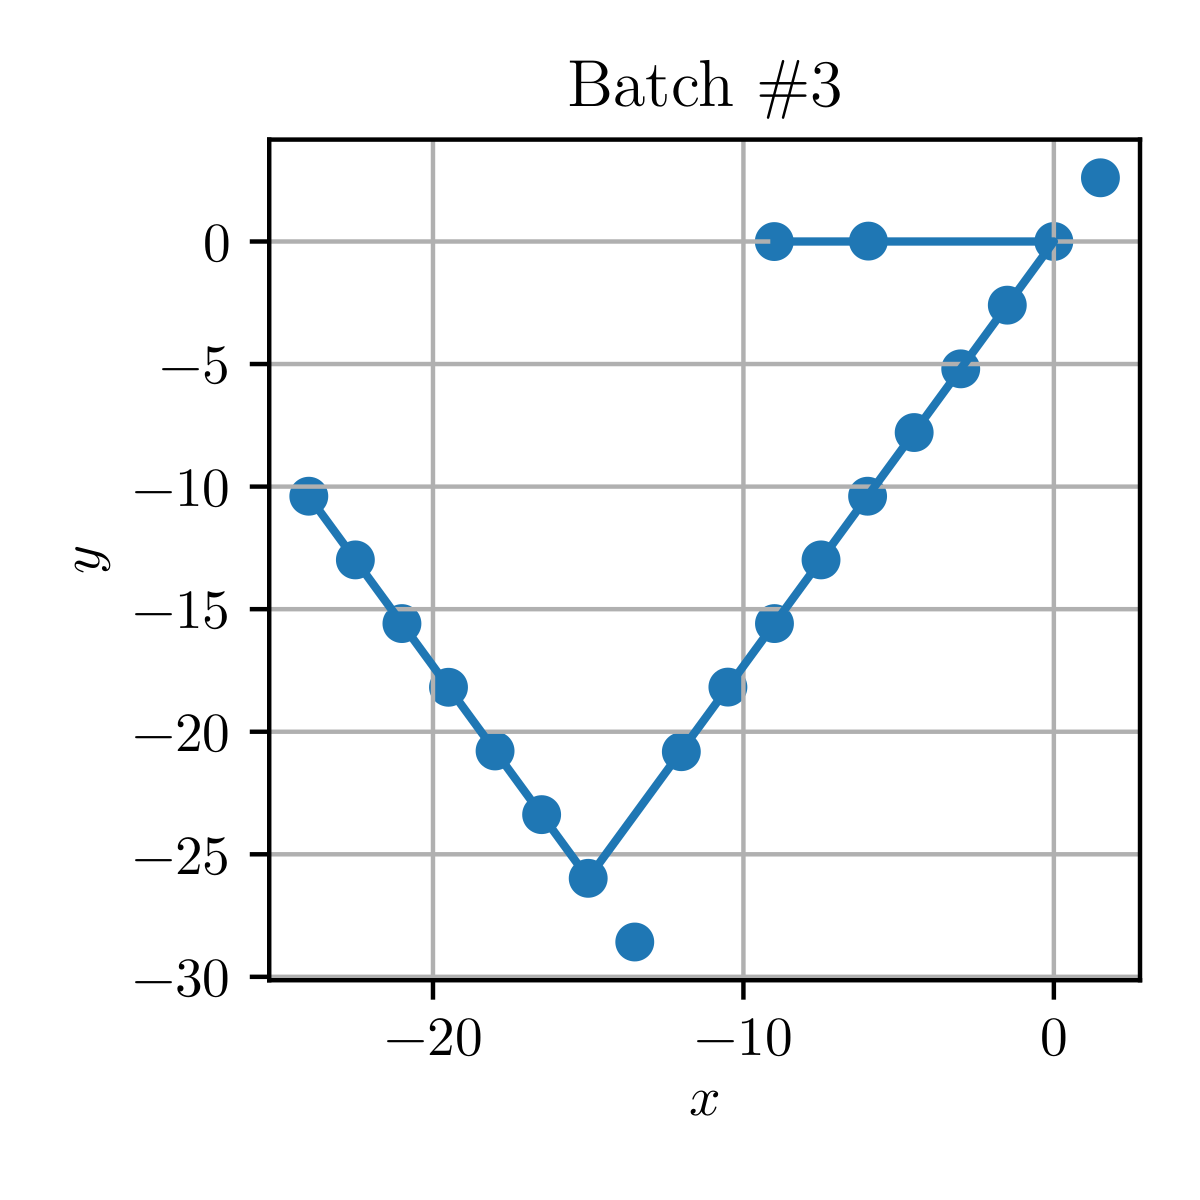
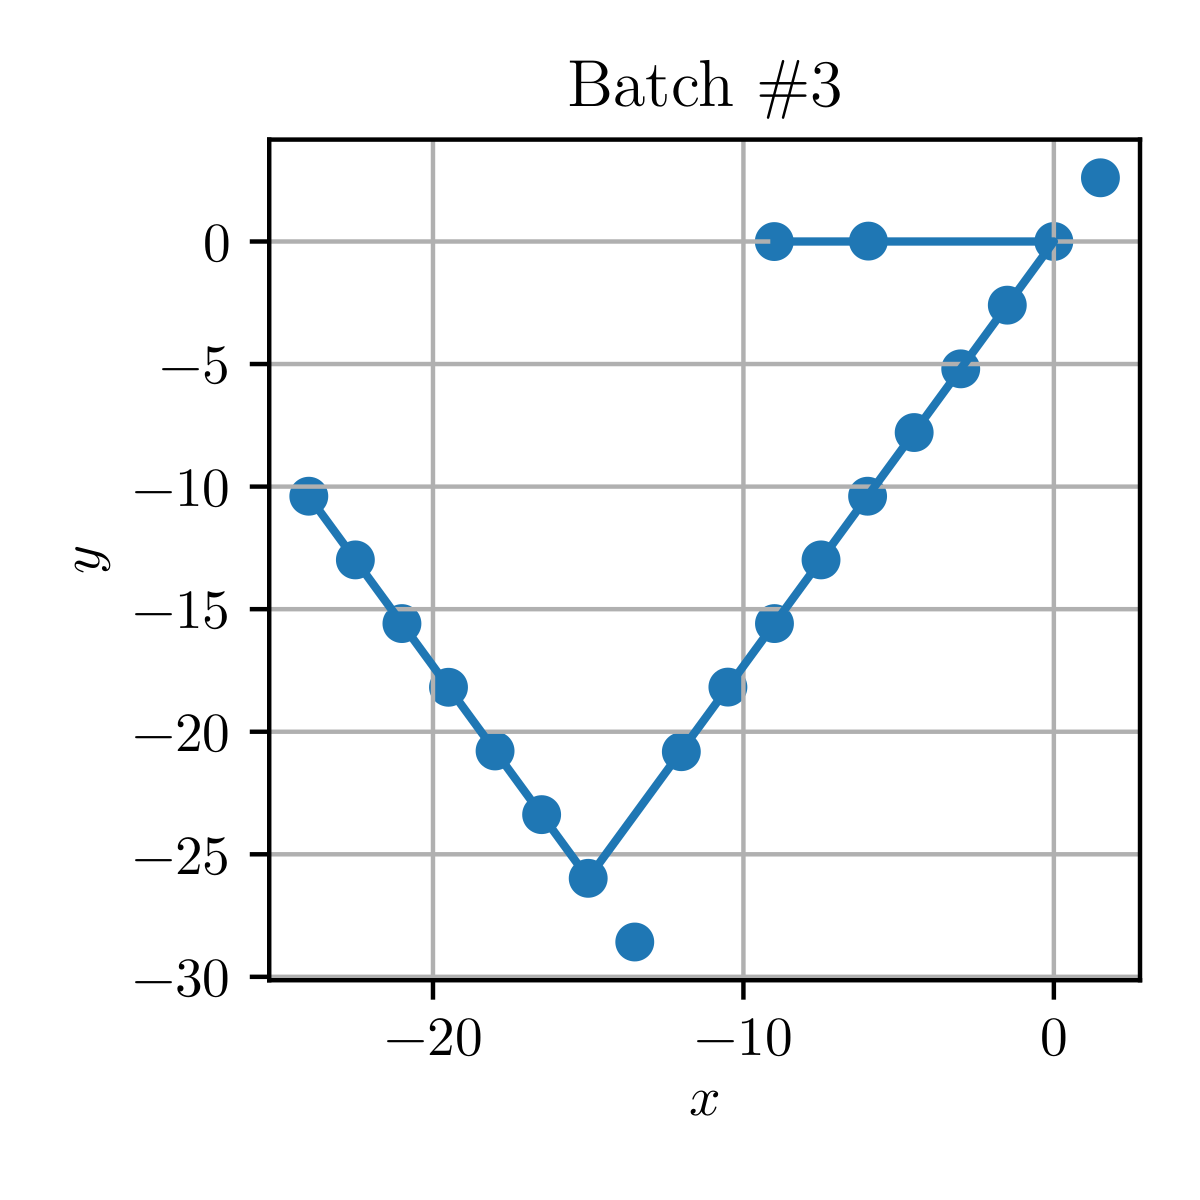
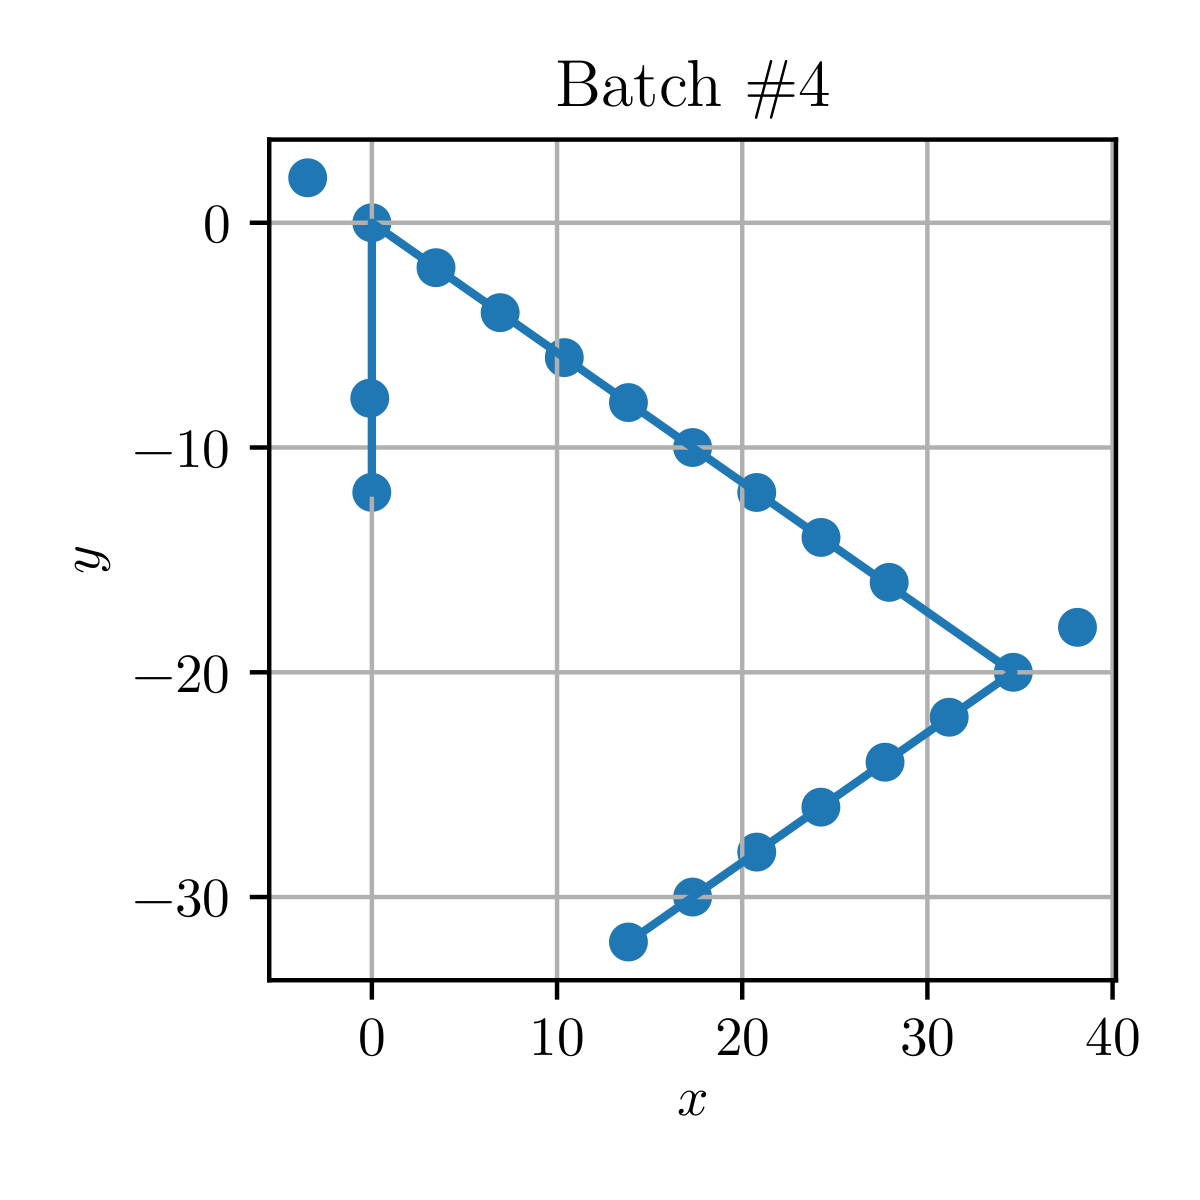
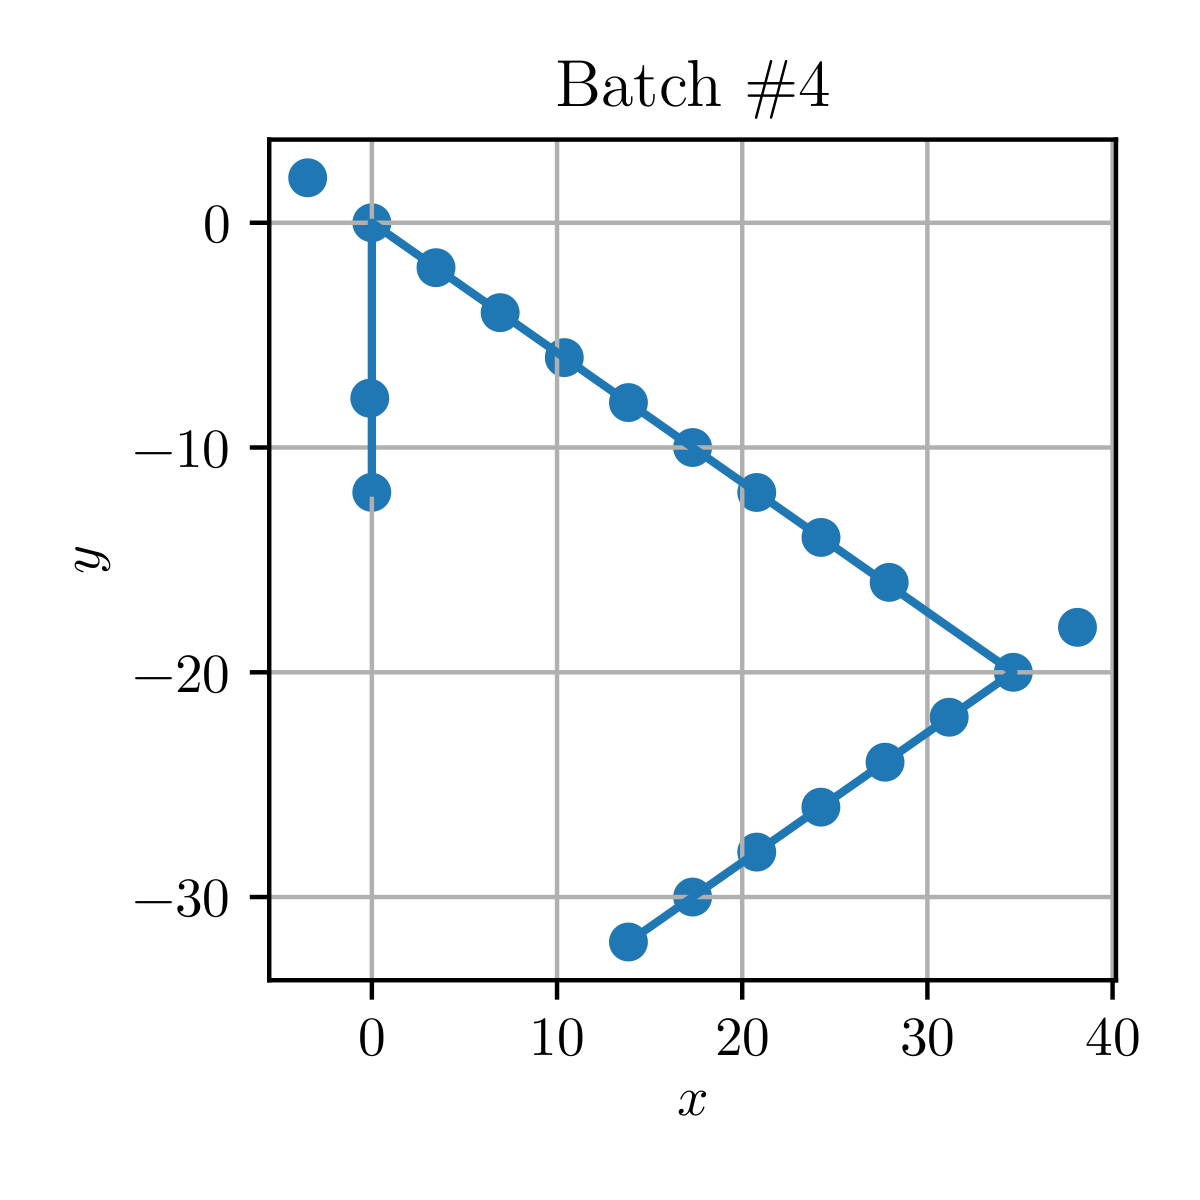

In [13]:
@ftl.with_context
def plot(X_pred, X, batch_idx, file_name):
    fig, ax = plt.subplots()
    ax.scatter(X_pred[batch_idx, 0], X_pred[batch_idx, 1])
    ax.plot(X[batch_idx, 0], X[batch_idx, 1])
    ax.grid()
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_title(f'Batch \#{batch_idx + 1}')
    return ftl.save_fig(fig, file_name, resize=(3, 3))

ftl.img_grid([
    plot(X_pred[:, :, :20], X[:, :, -1, :20], 0, 'pred_b1_train'),
    plot(X_pred[:, :, :20], X[:, :, -1, :20], 1, 'pred_b2_train'),
    plot(X_pred[:, :, :20], X[:, :, -1, :20], 2, 'pred_b3_train'),
    plot(X_pred[:, :, :20], X[:, :, -1, :20], 3, 'pred_b4_train'),
], n_columns=4)

[Download loss_b1_train.png],[Download loss_b2_train.png],[Download loss_b3_train.png],[Download loss_b4_train.png]

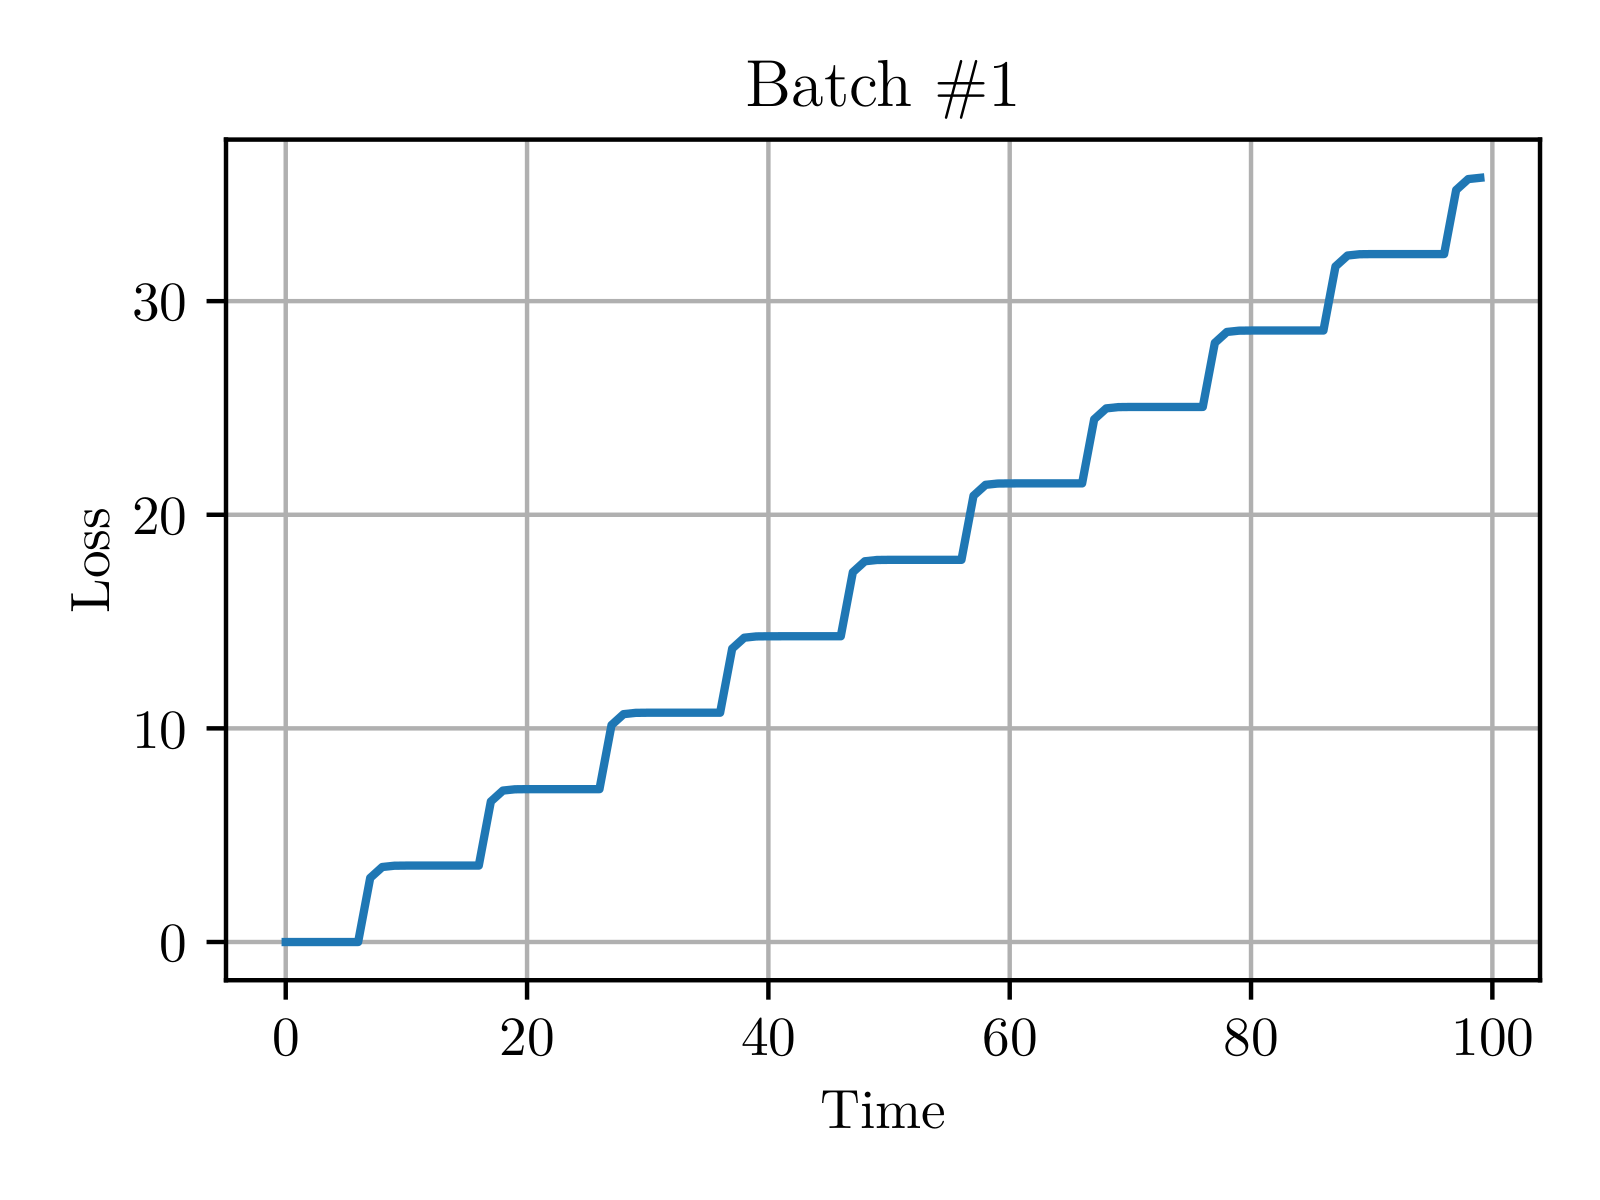
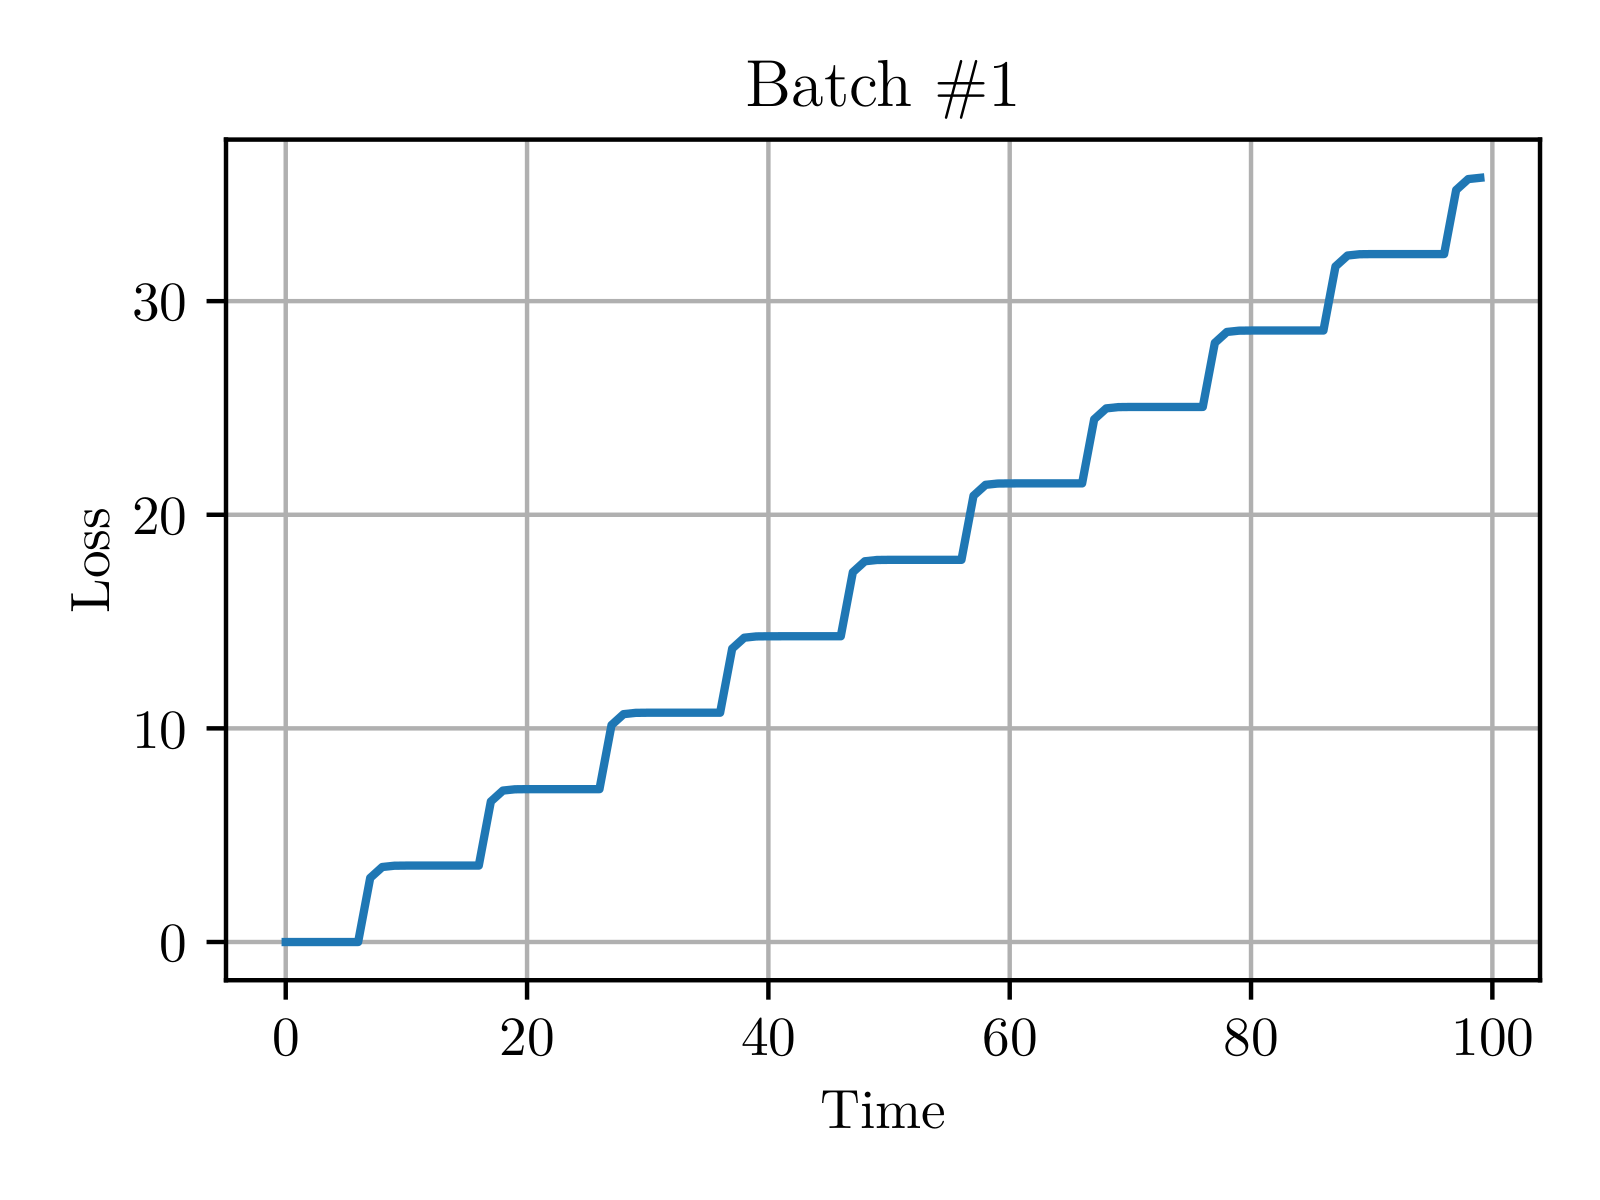
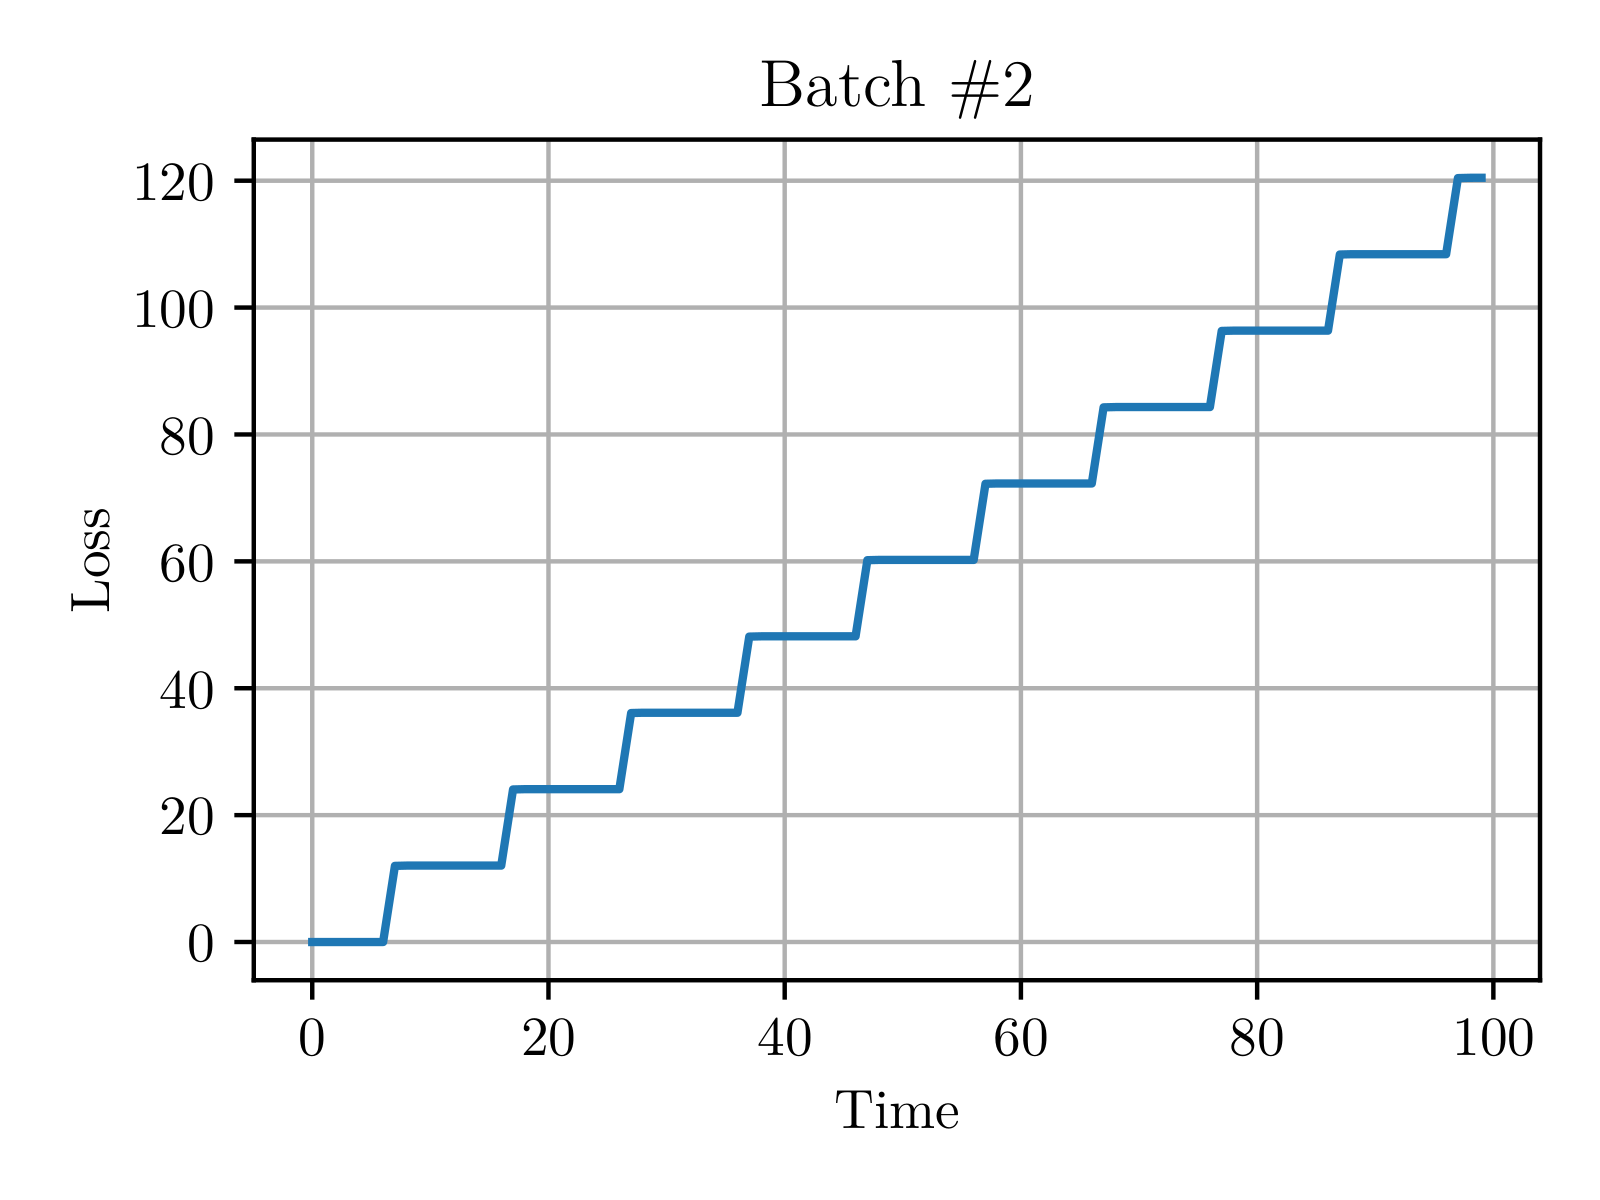
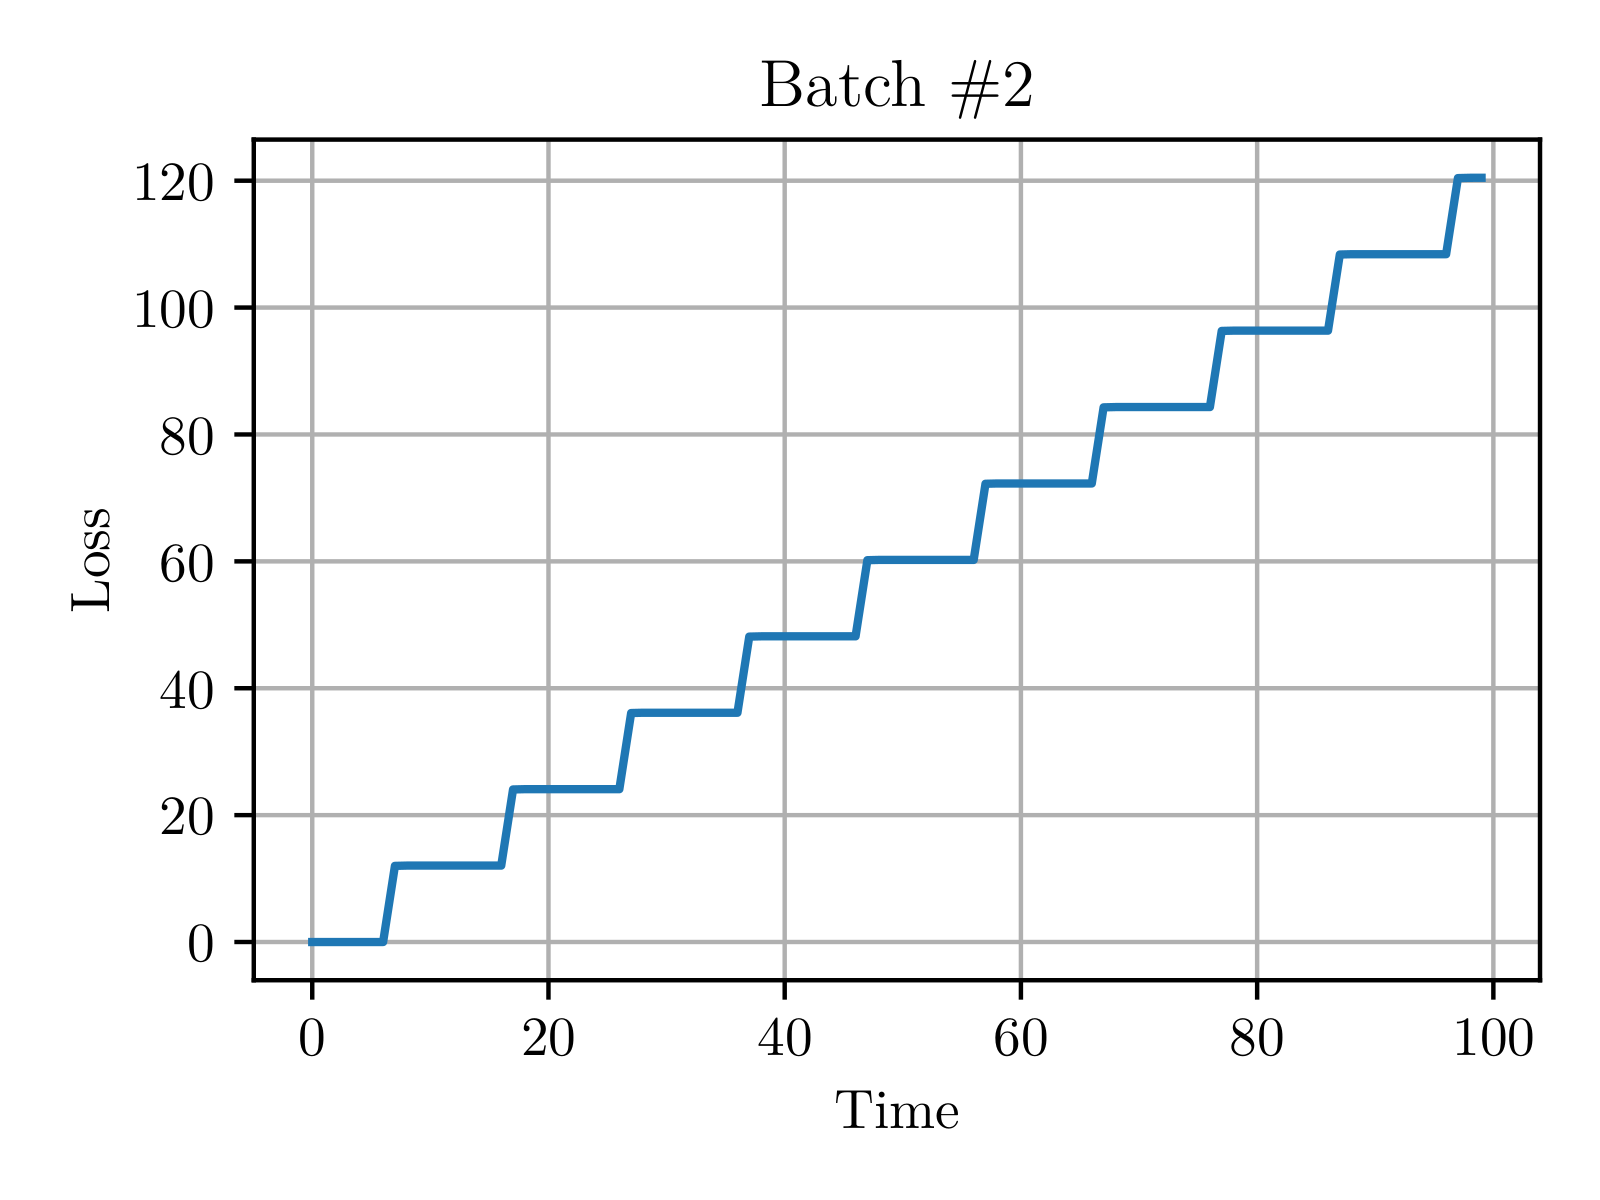
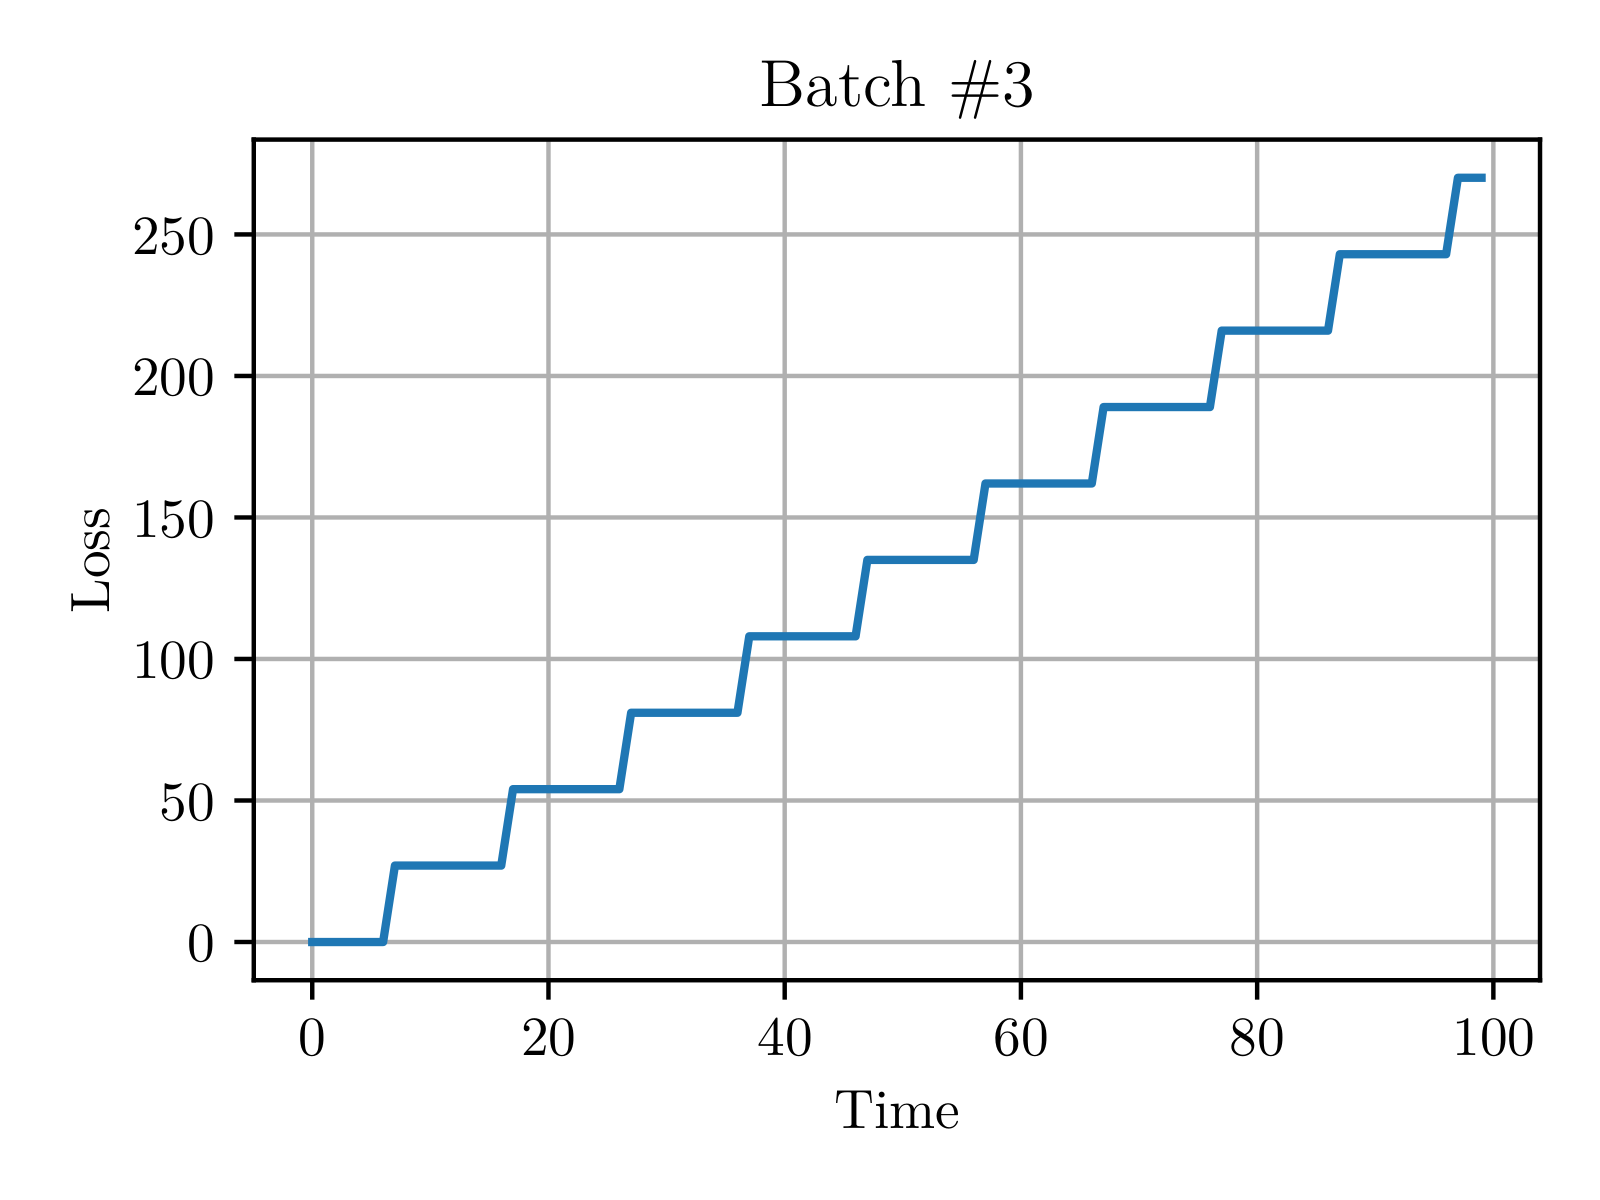
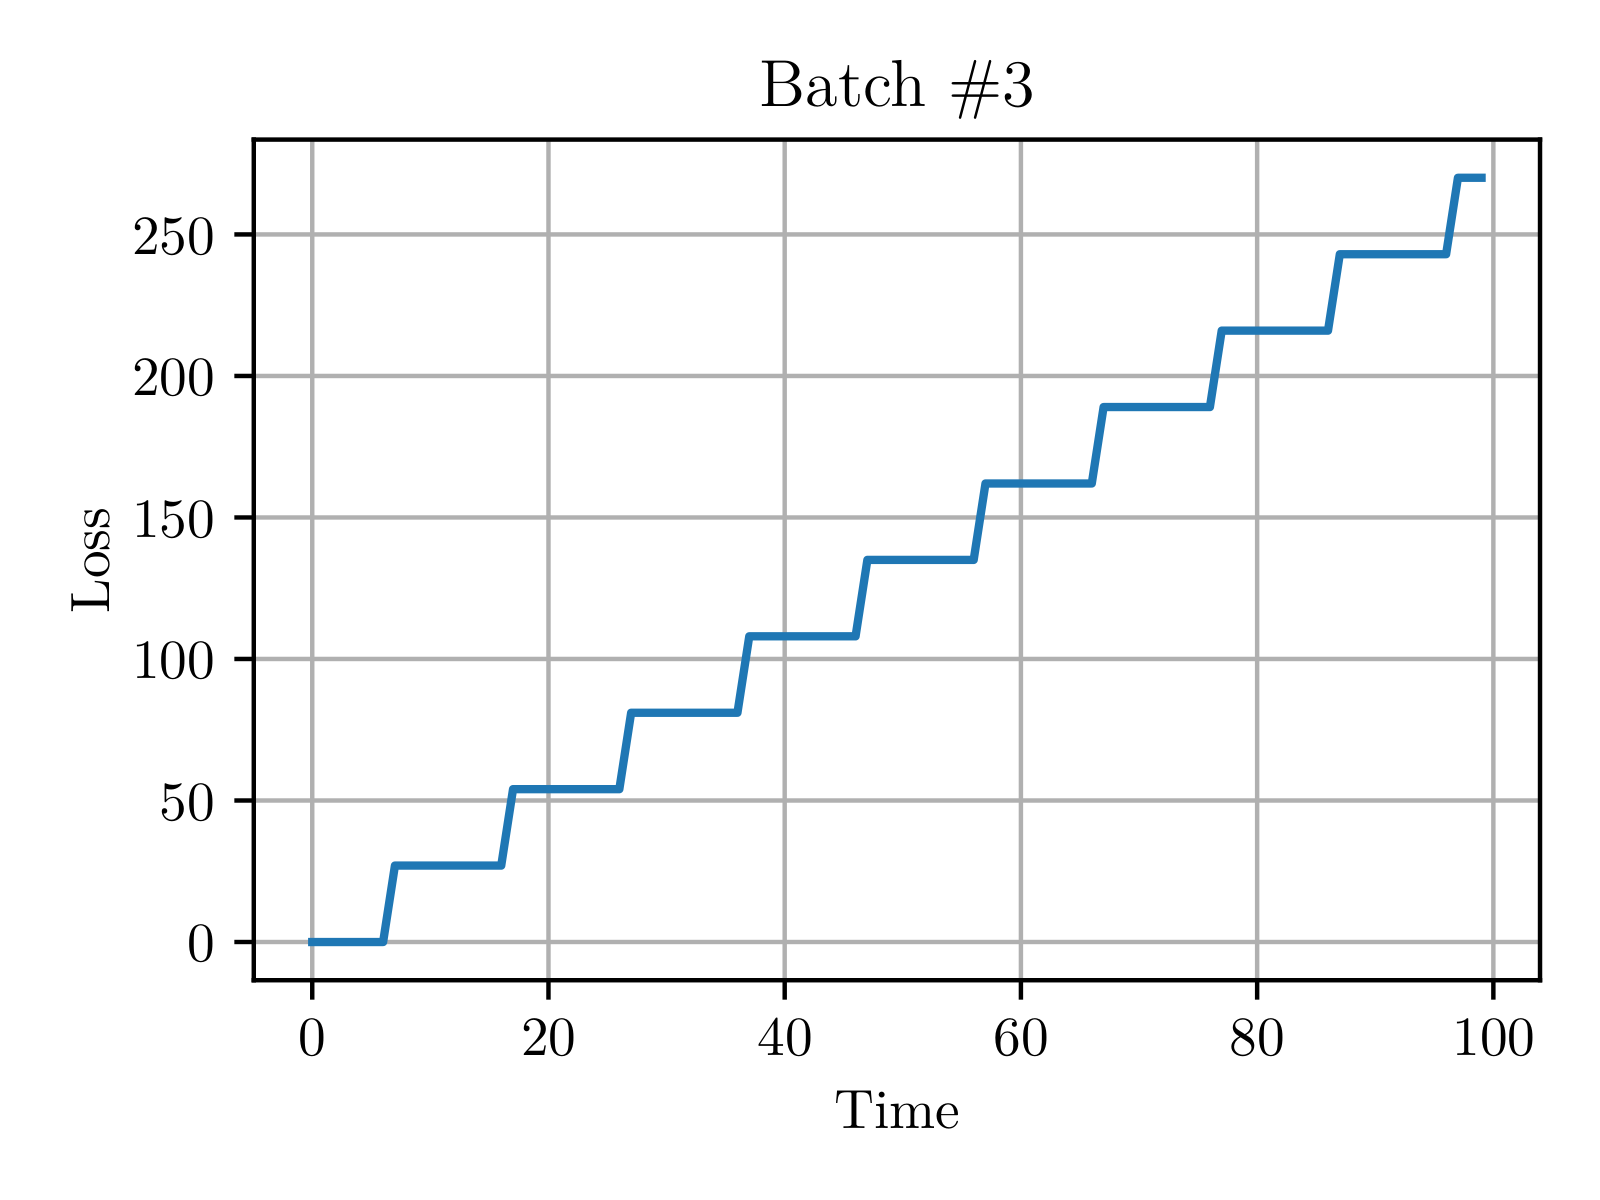
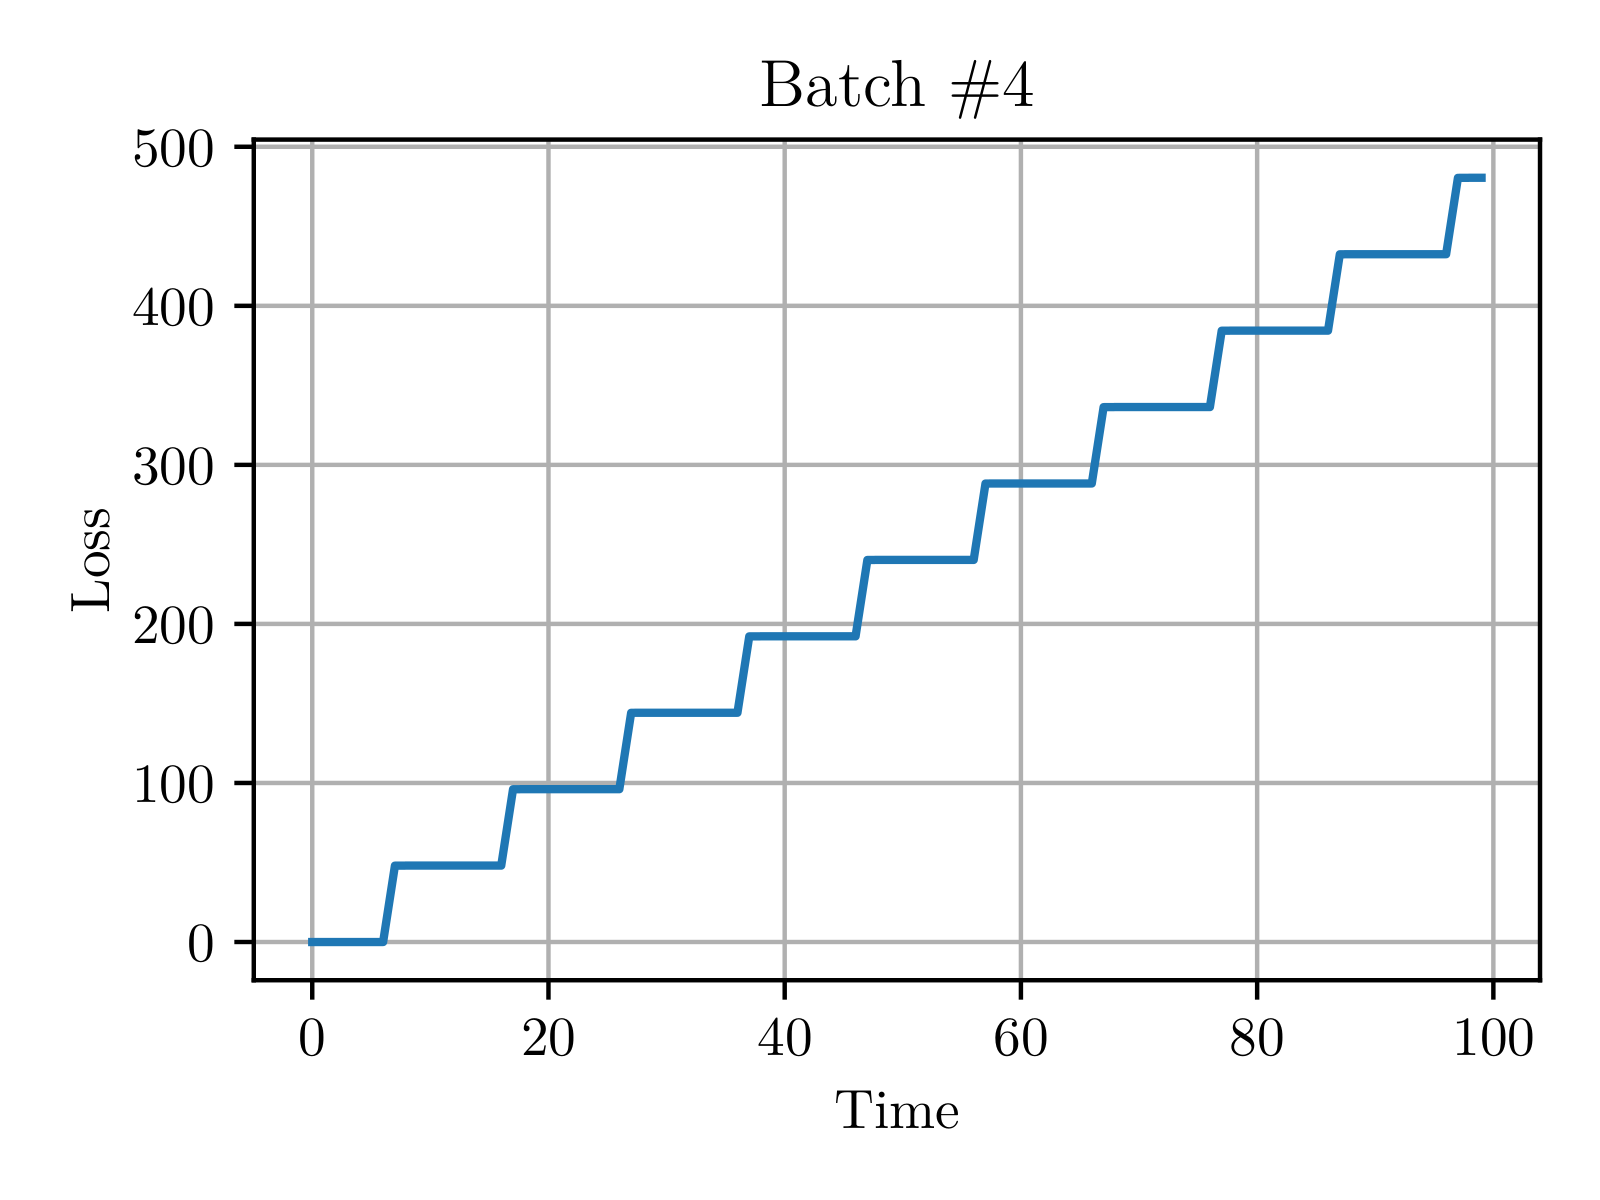
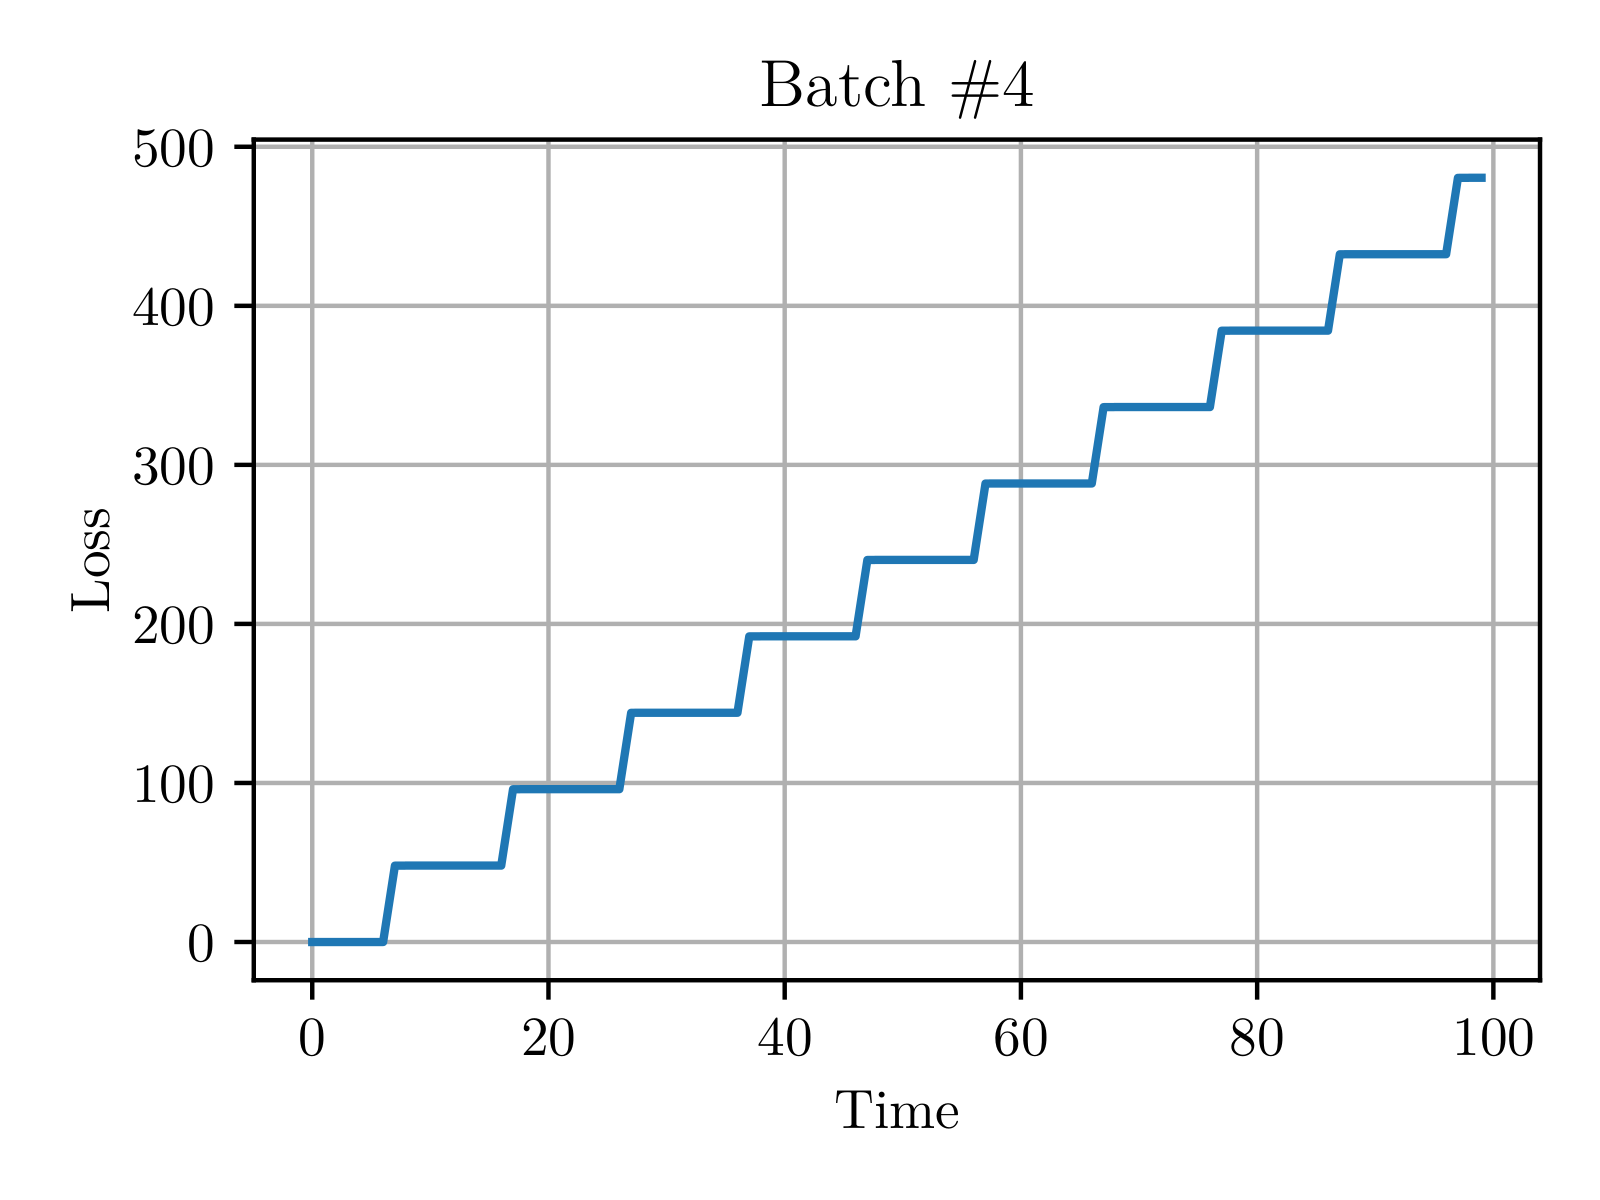

In [14]:
@ftl.with_context
def plot(loss, batch_idx, file_name):
    fig, ax = plt.subplots()
    ax.plot(loss[batch_idx])
    ax.grid()
    ax.set_xlabel('Time')
    ax.set_ylabel('Loss')
    ax.set_title(f'Batch \#{batch_idx + 1}')
    return ftl.save_fig(fig, file_name)

losses = torch.cumsum(torch.sum((X[:, :, -1] - X_pred)**2, dim=1), dim=1)
ftl.img_grid([
    plot(losses, 0, 'loss_b1_train'),
    plot(losses, 1, 'loss_b2_train'),
    plot(losses, 2, 'loss_b3_train'),
    plot(losses, 3, 'loss_b4_train'),
], n_columns=4)

In [15]:
X, _ = data_loader()

In [16]:
X_pred = evaluate(X, state_cov=state_cov, process_noise=process_noise, measurement_noise=measurement_noise)
X_pred.shape

torch.Size([4, 2, 210])

[Download pred_b1.png],[Download pred_b2.png],[Download pred_b3.png],[Download pred_b4.png]

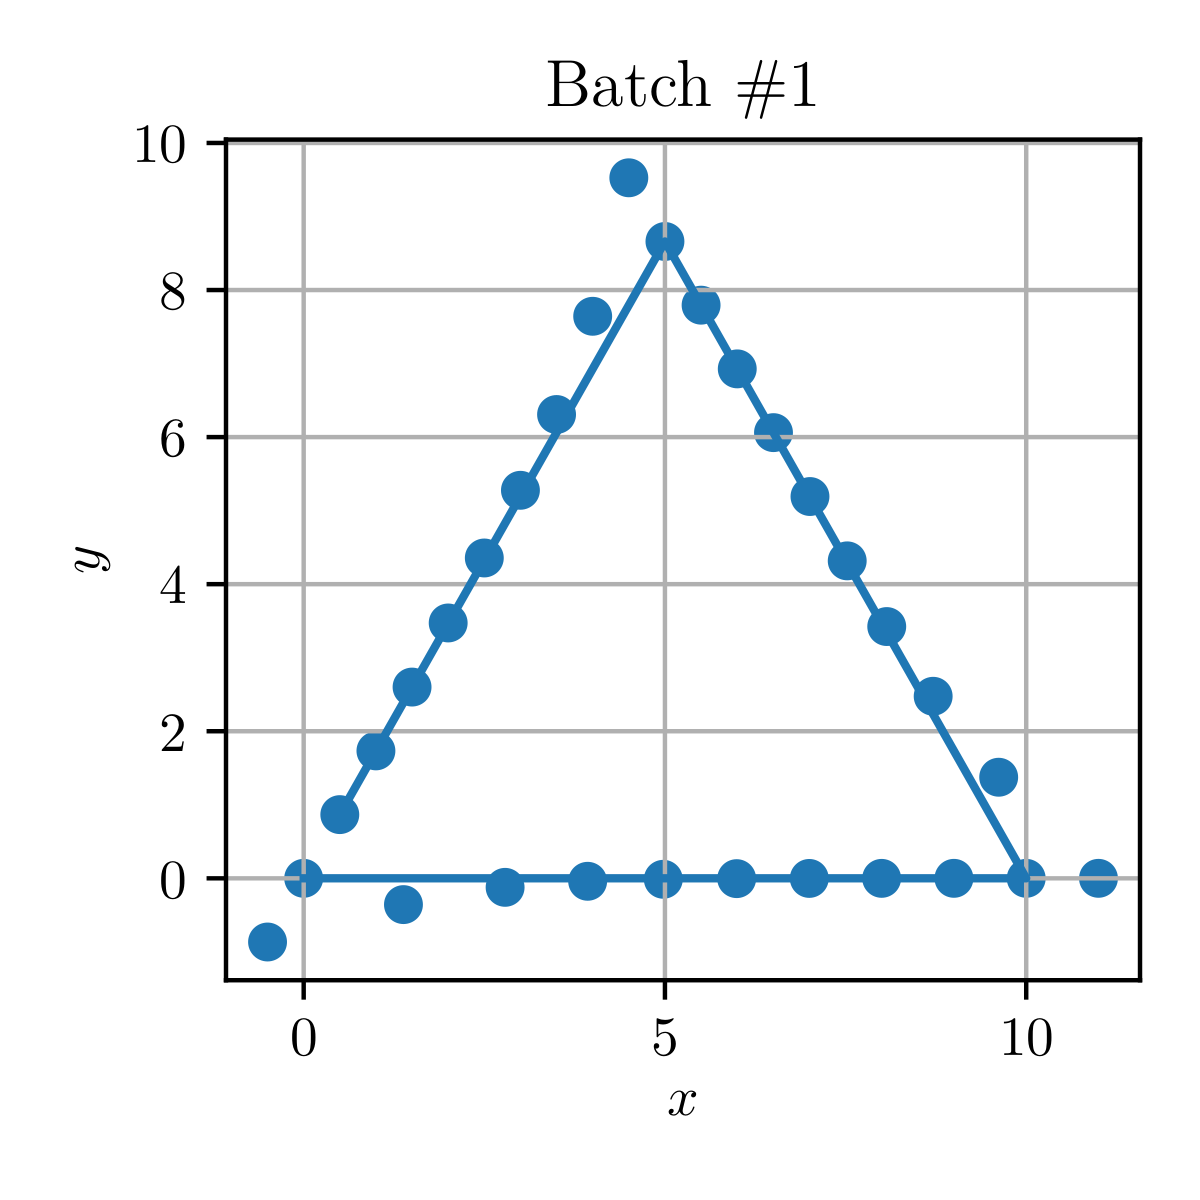
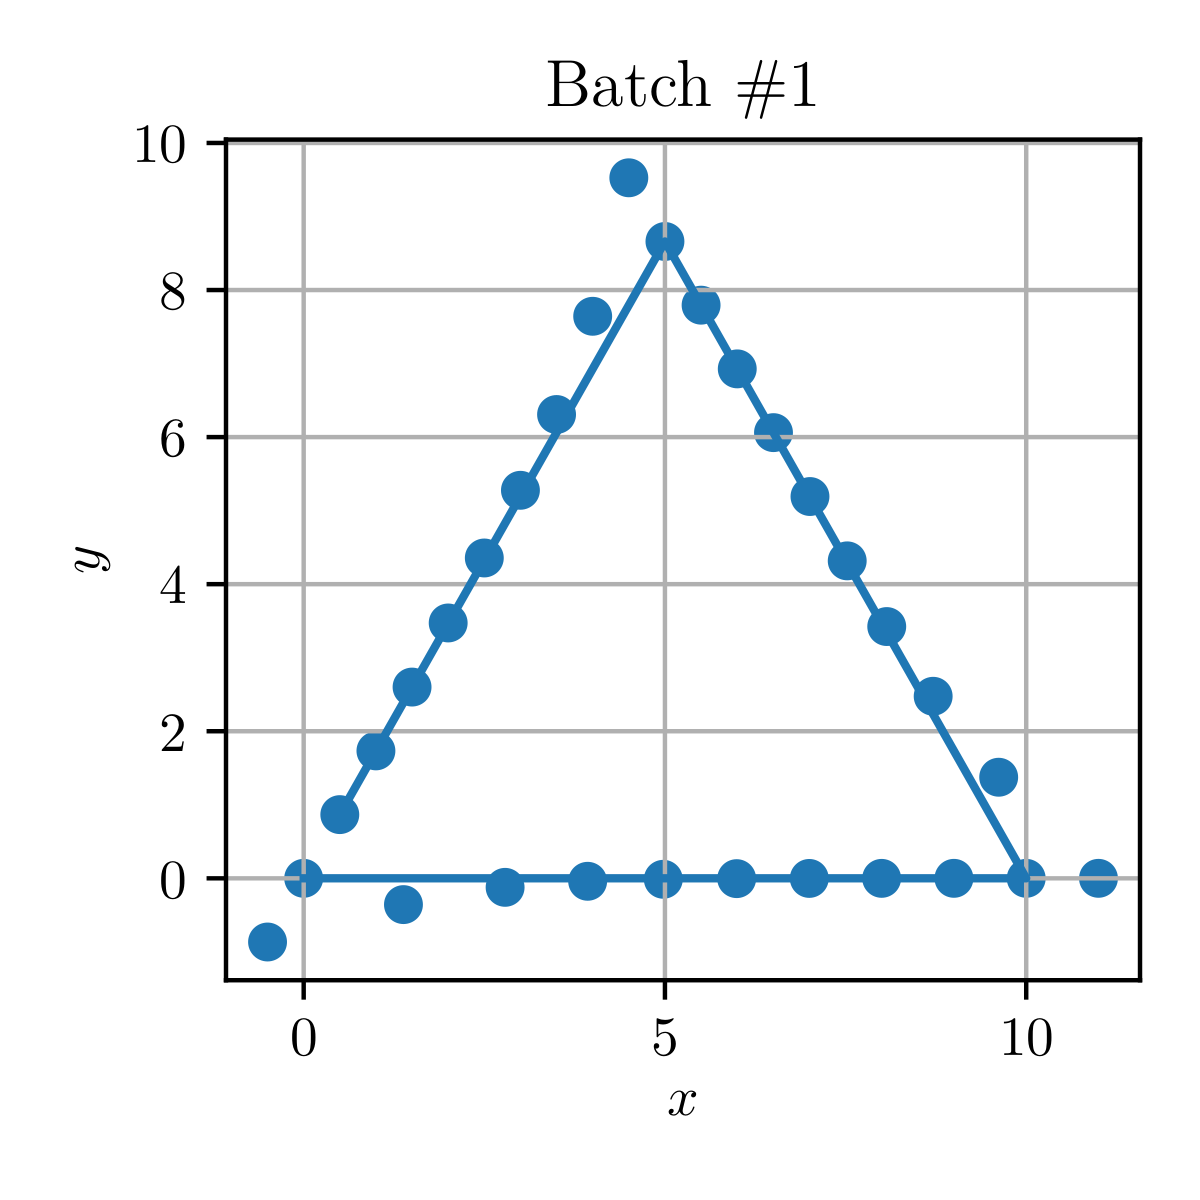
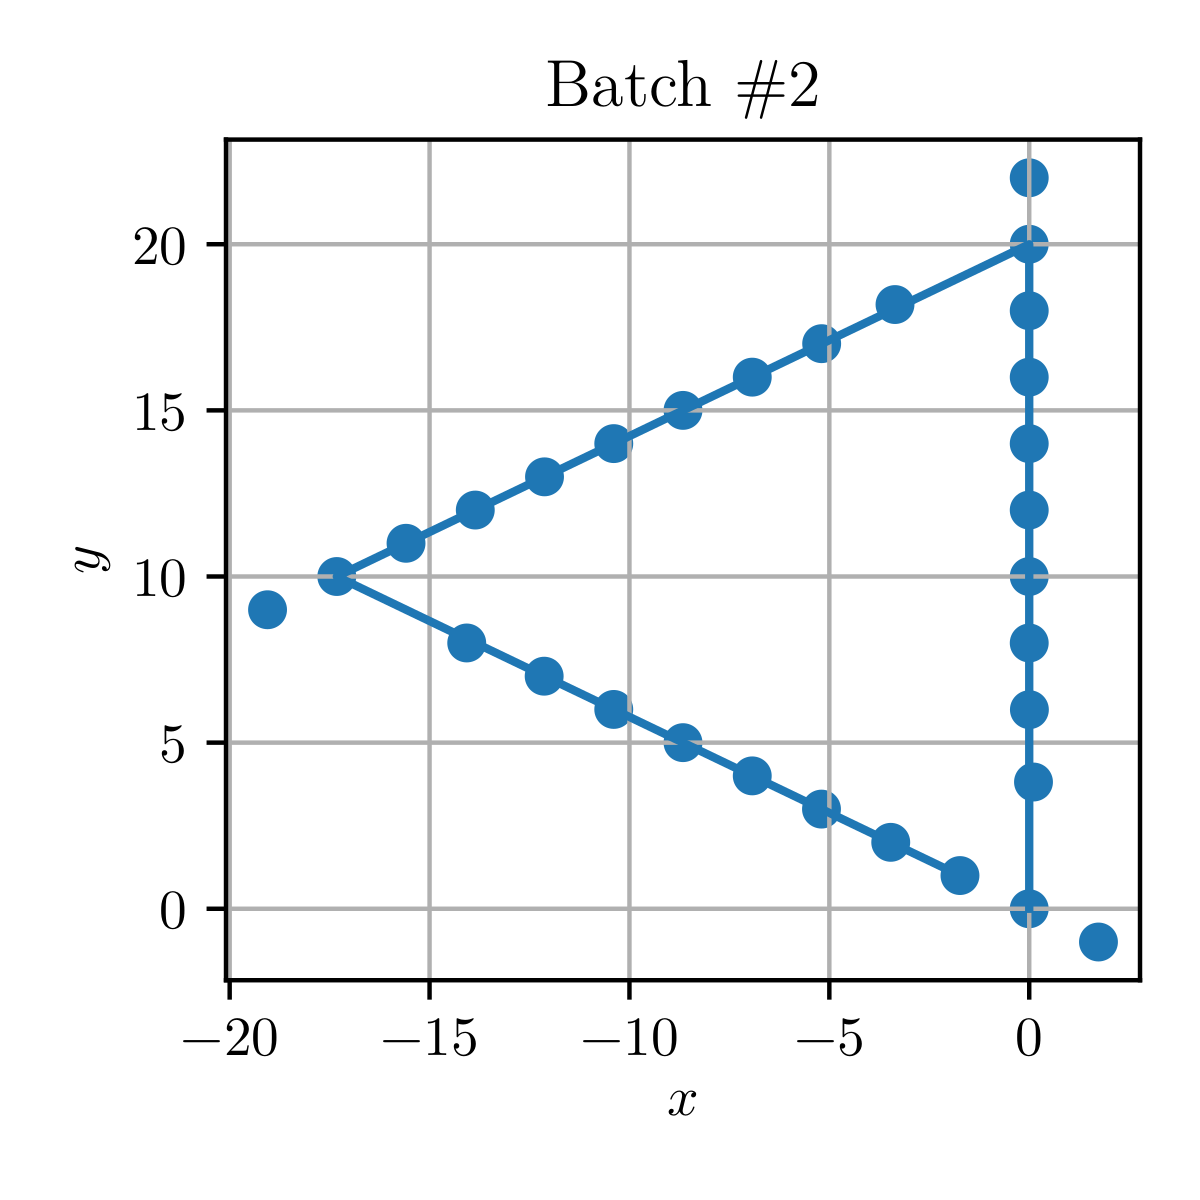
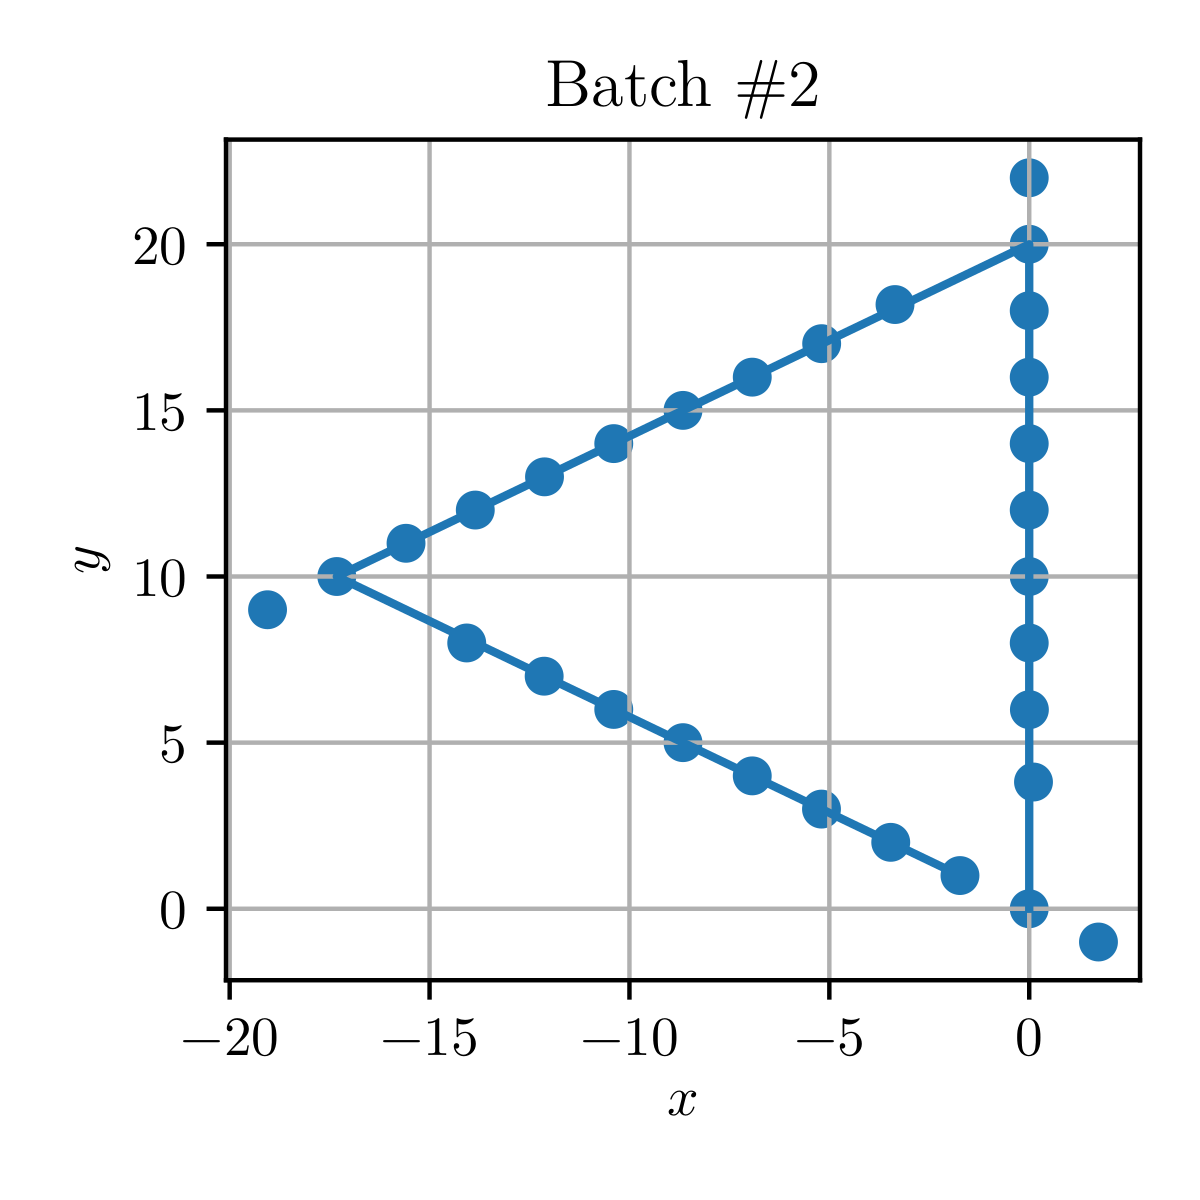
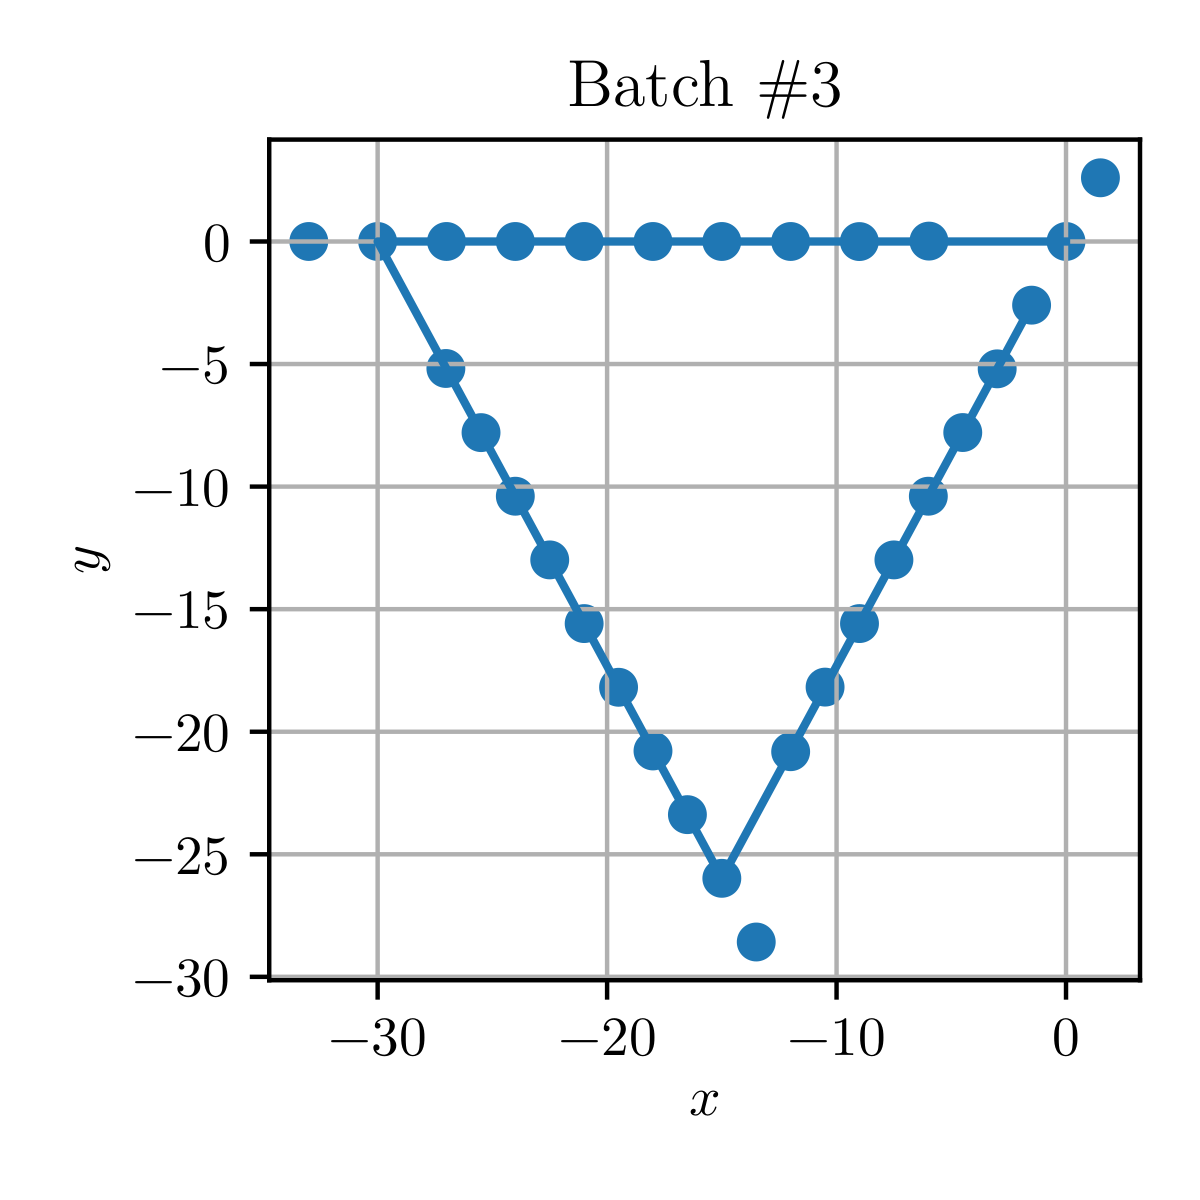
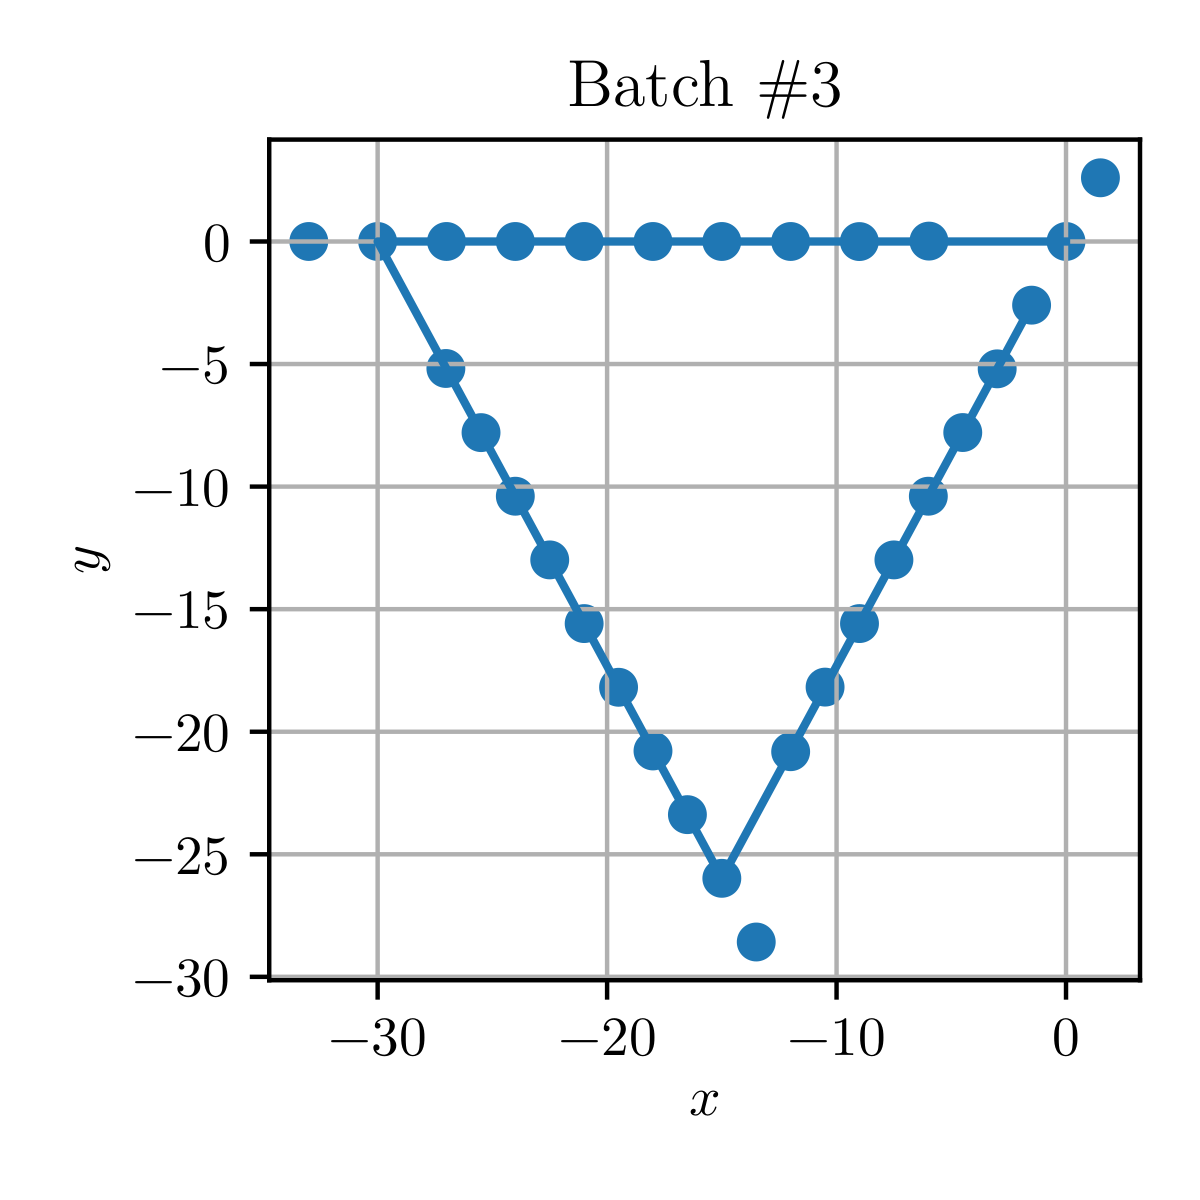
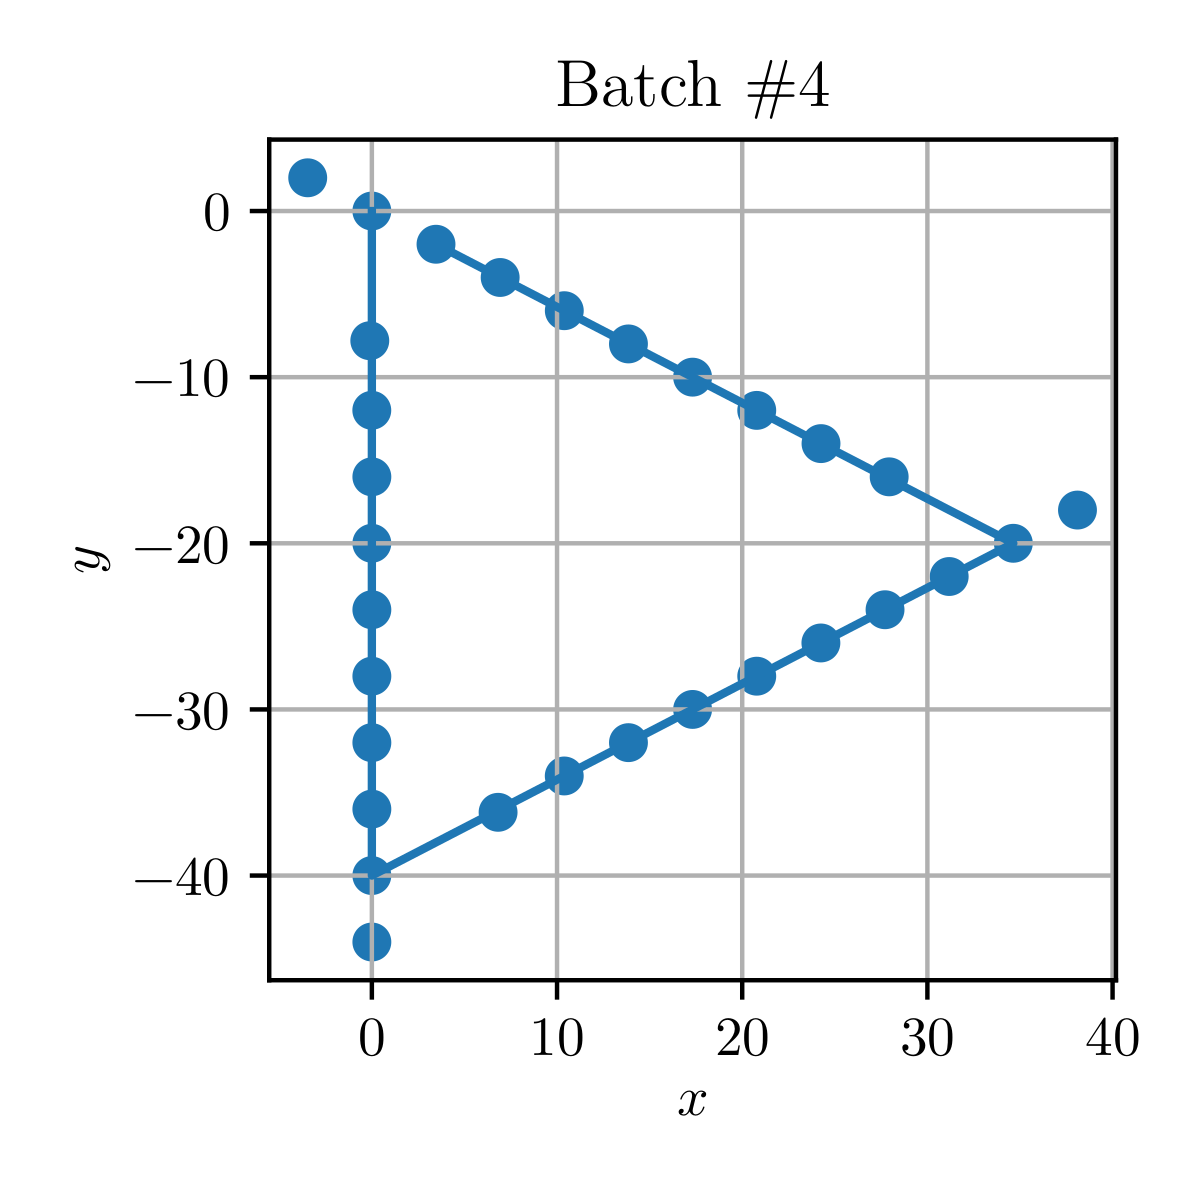
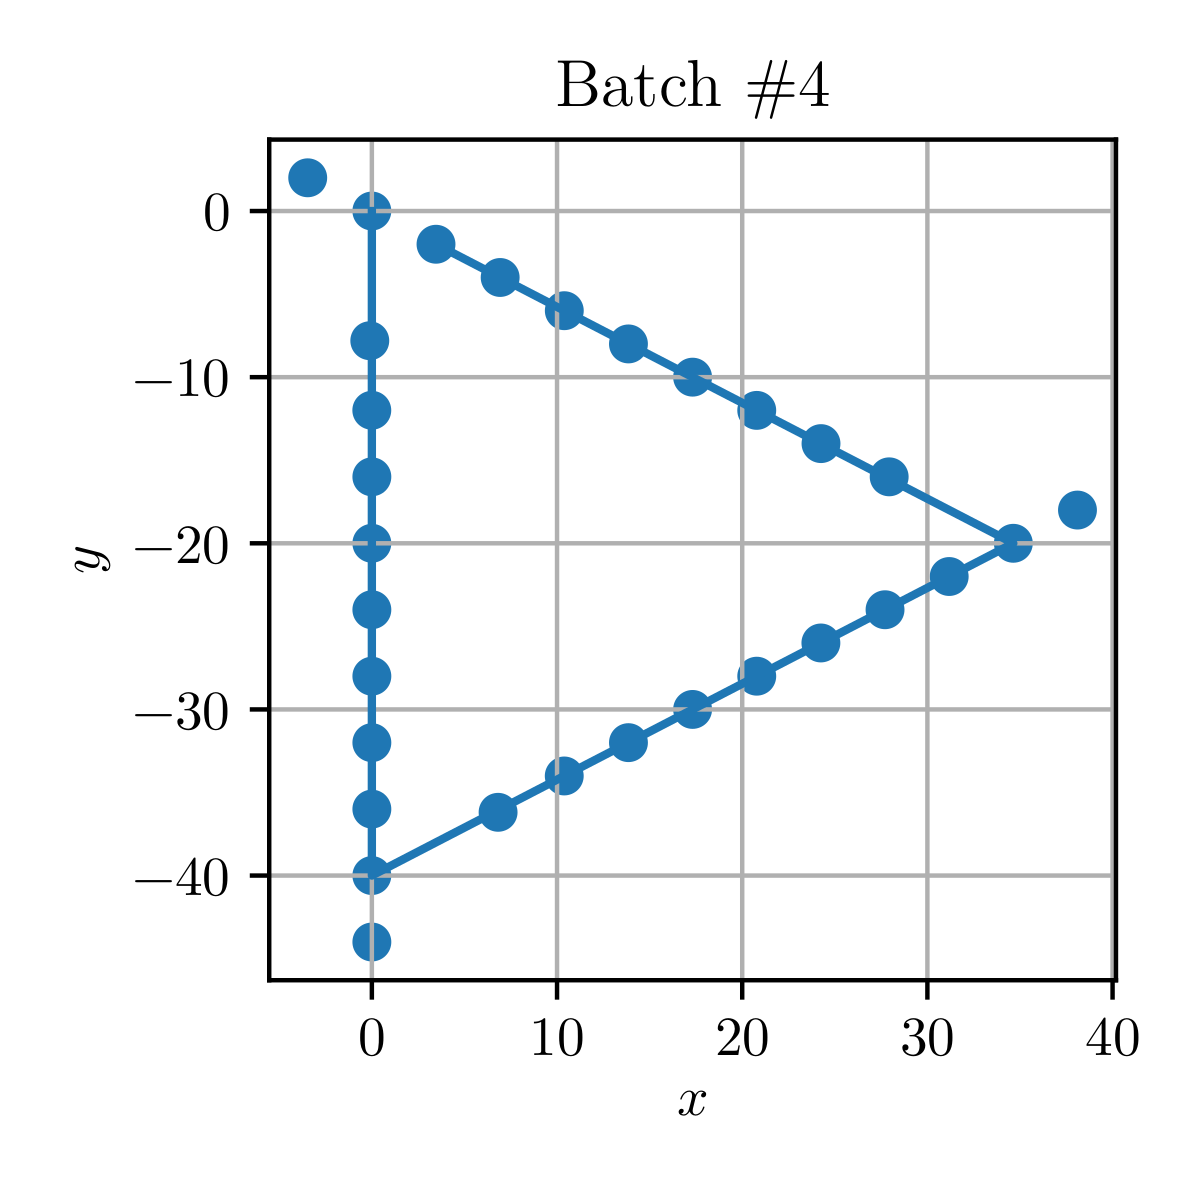

In [17]:
@ftl.with_context
def plot(X_pred, X, batch_idx, file_name):
    fig, ax = plt.subplots()
    ax.scatter(X_pred[batch_idx, 0], X_pred[batch_idx, 1])
    ax.plot(X[batch_idx, 0], X[batch_idx, 1])
    ax.grid()
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_title(f'Batch \#{batch_idx + 1}')
    return ftl.save_fig(fig, file_name, resize=(3, 3))

ftl.img_grid([
    plot(X_pred[:, :, -30:], X[:, :, -30:], 0, 'pred_b1'),
    plot(X_pred[:, :, -30:], X[:, :, -30:], 1, 'pred_b2'),
    plot(X_pred[:, :, -30:], X[:, :, -30:], 2, 'pred_b3'),
    plot(X_pred[:, :, -30:], X[:, :, -30:], 3, 'pred_b4'),
], n_columns=4)

[Download loss_b1.png],[Download loss_b2.png],[Download loss_b3.png],[Download loss_b4.png]

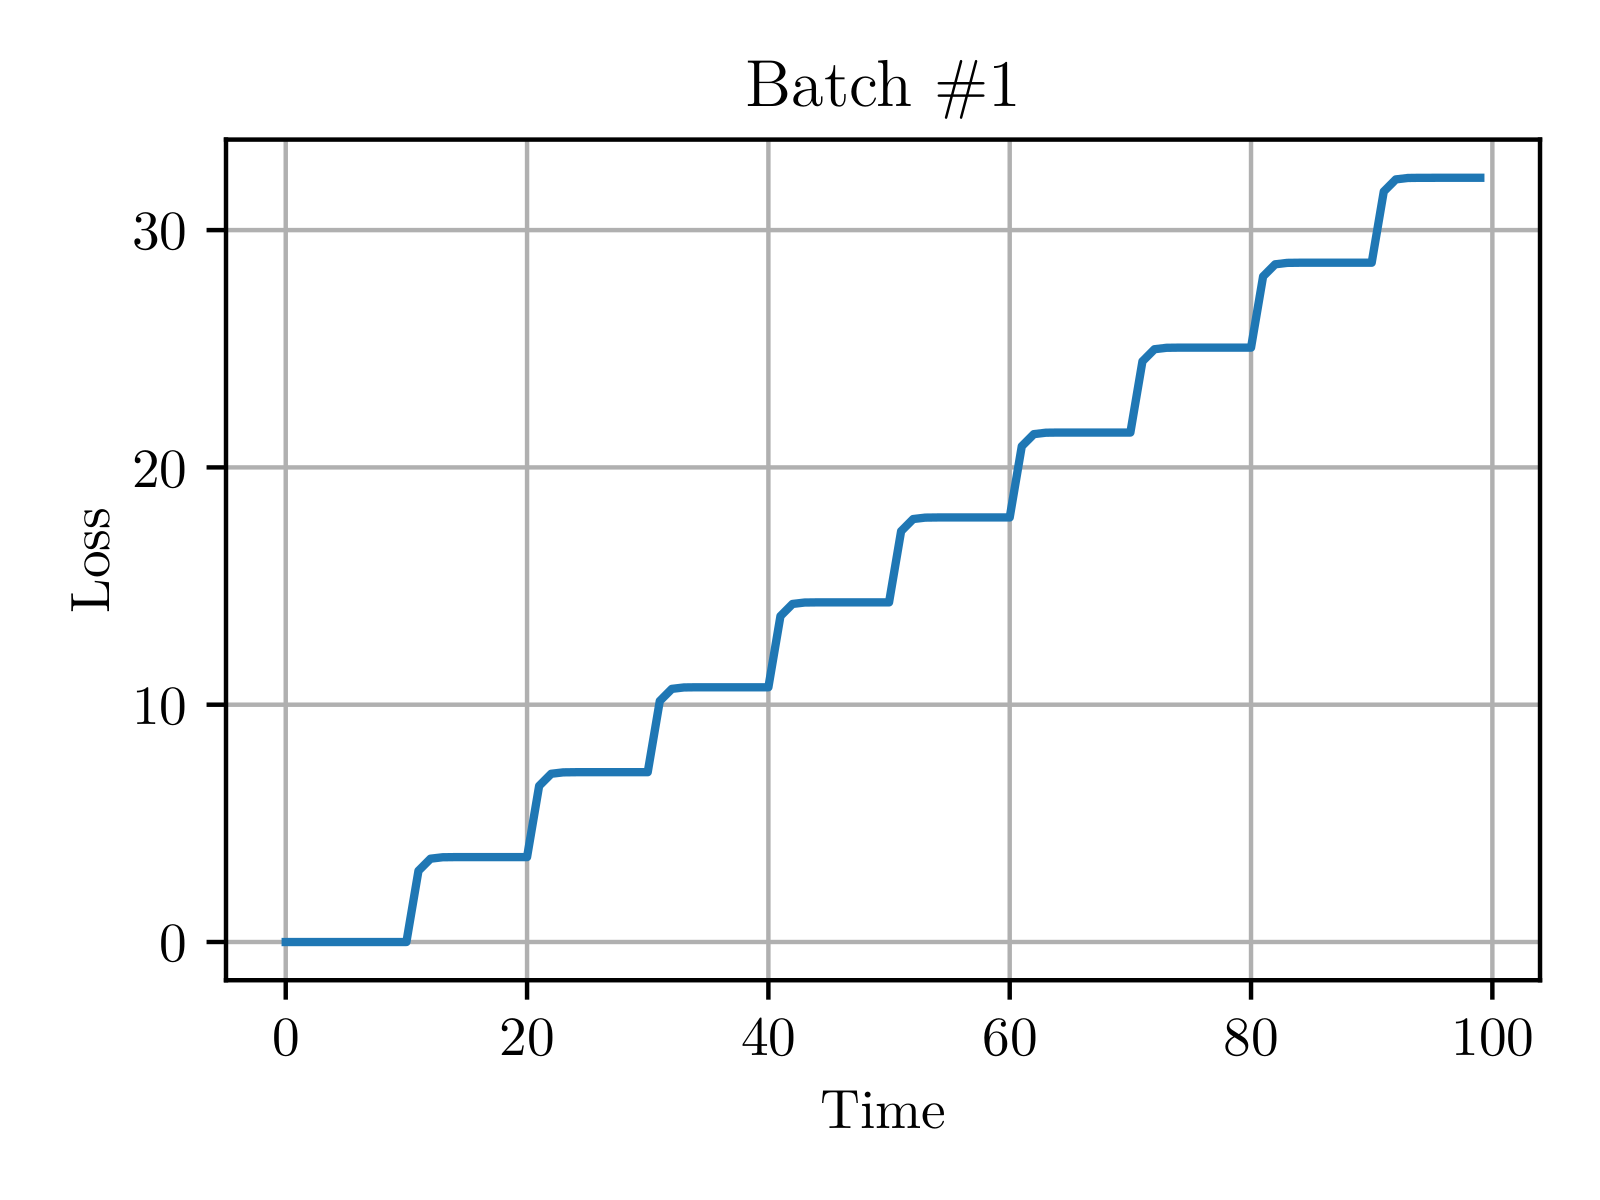
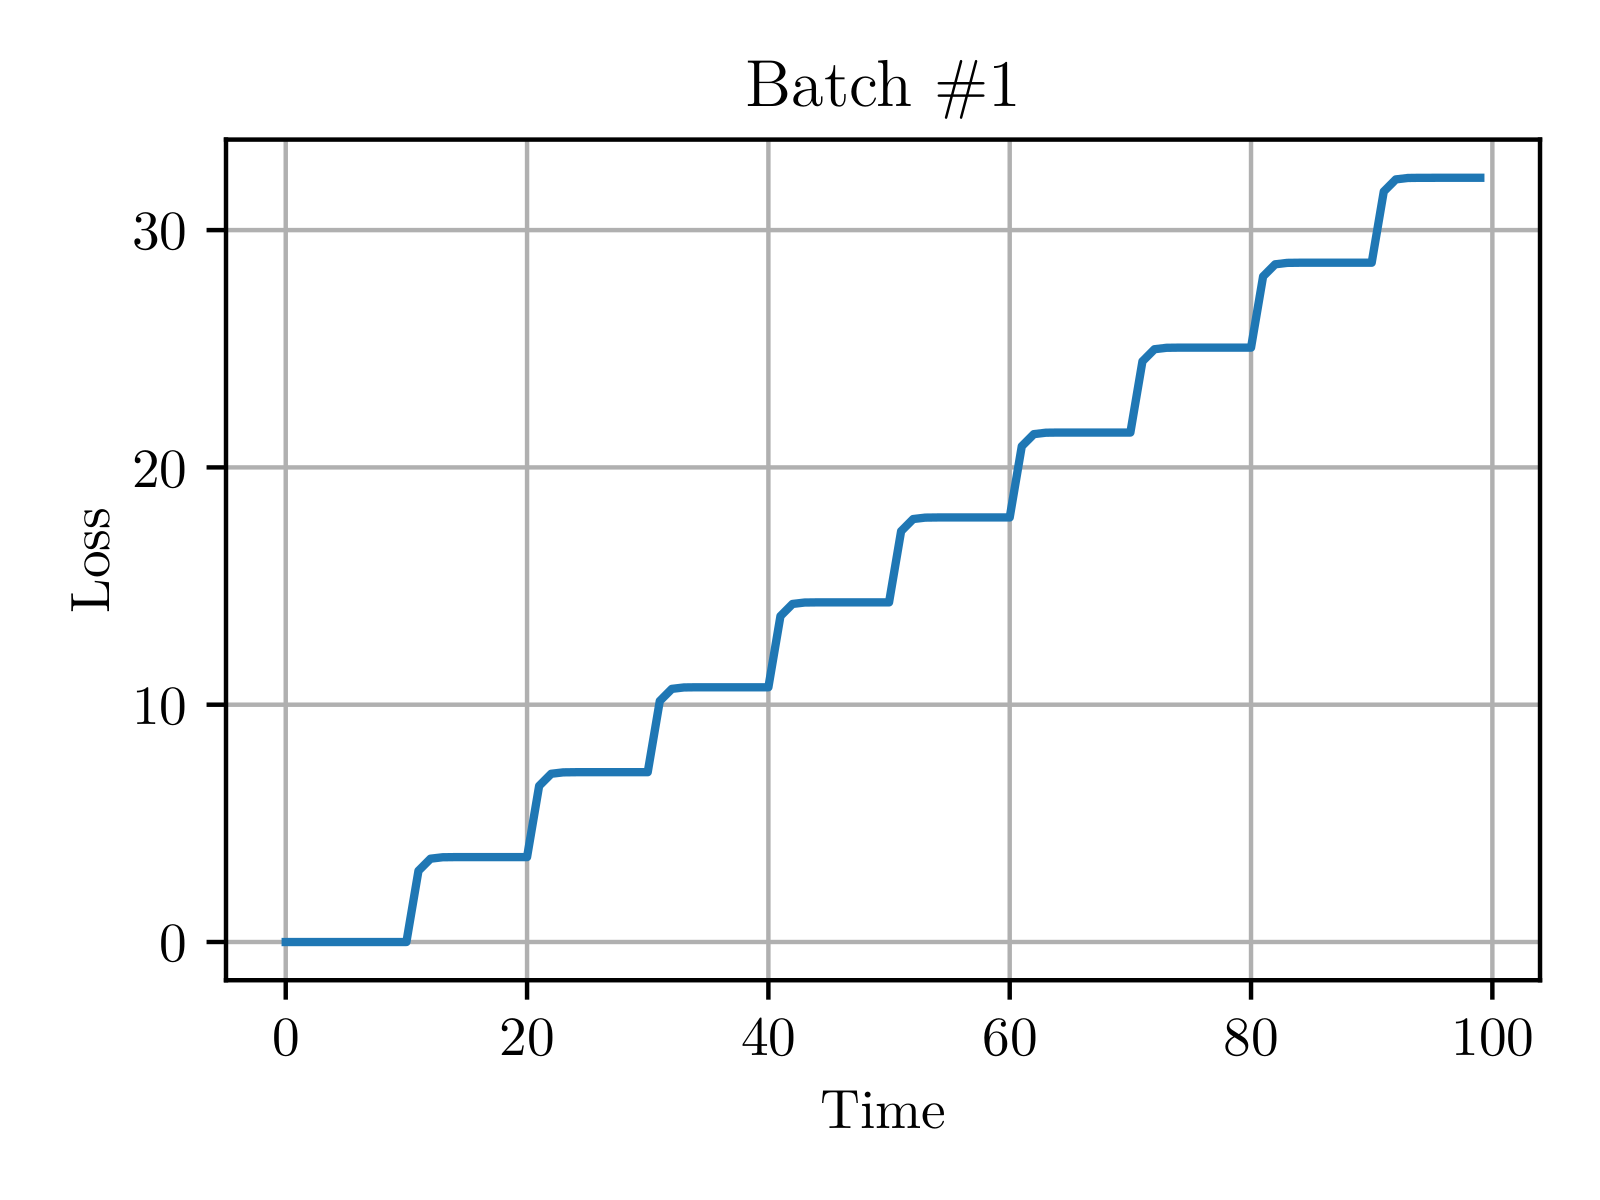
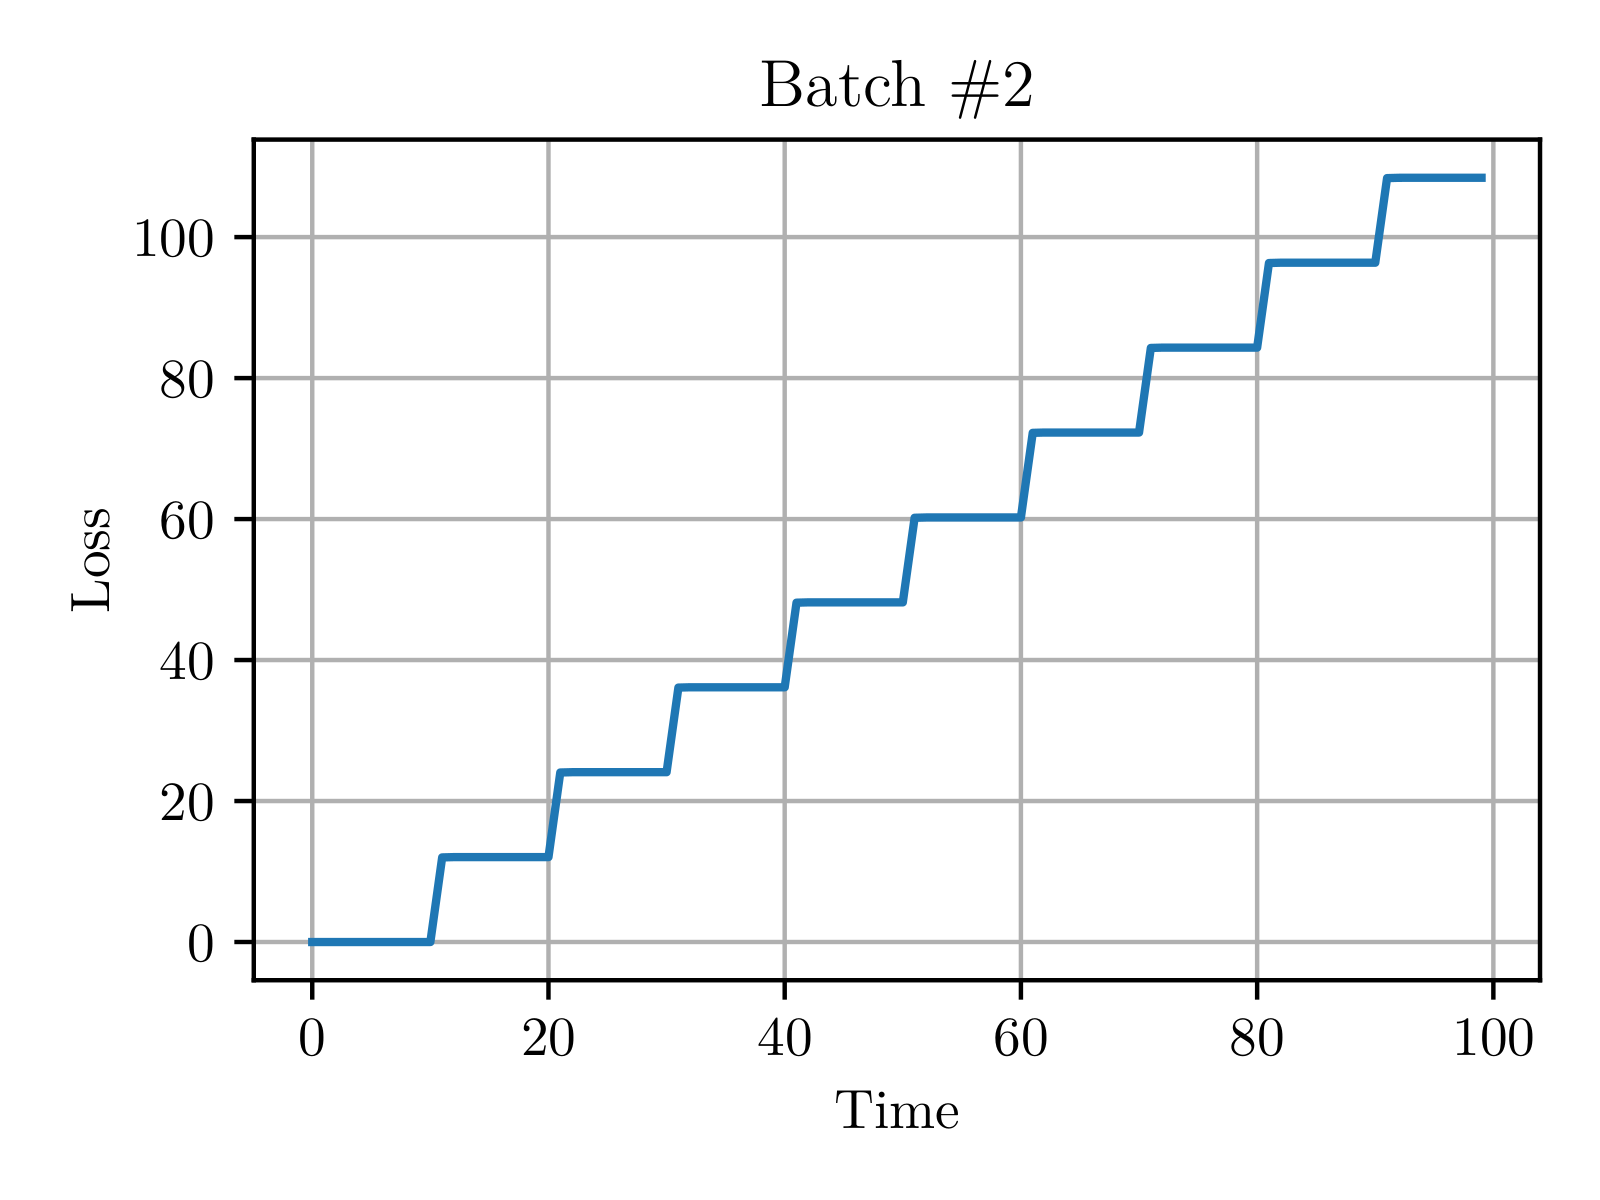
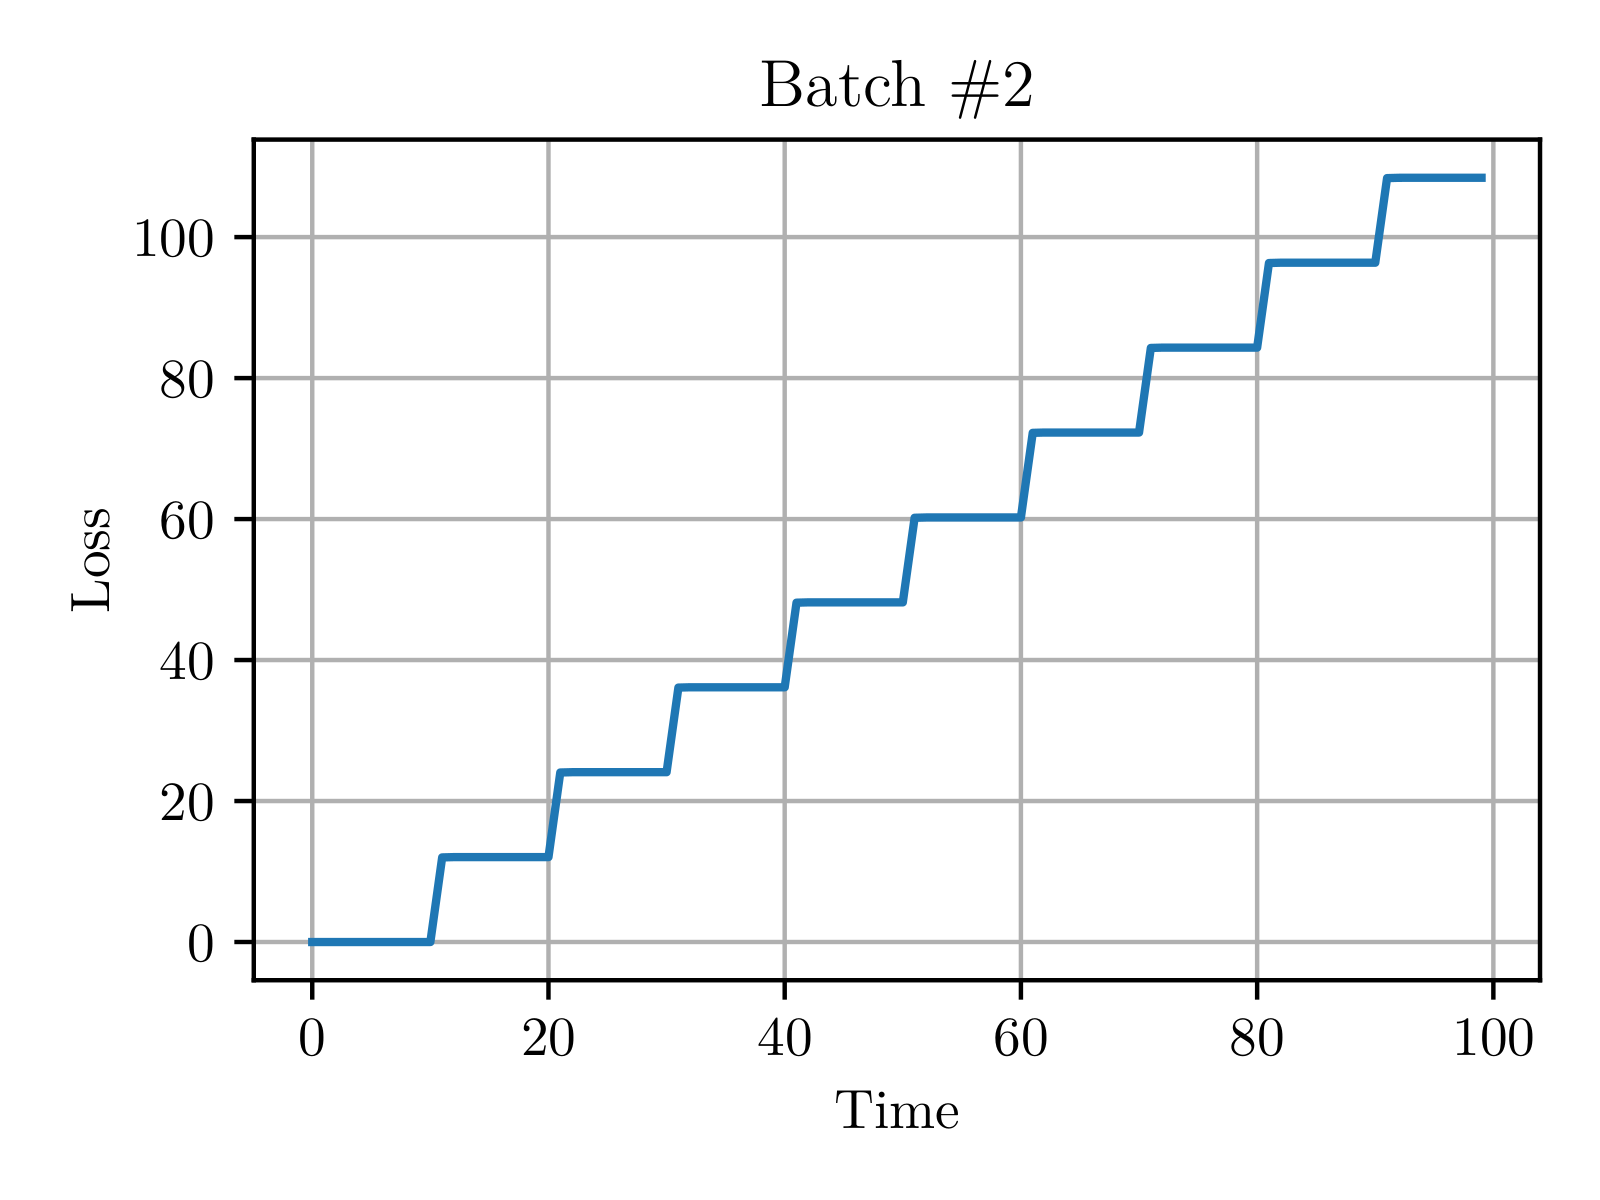
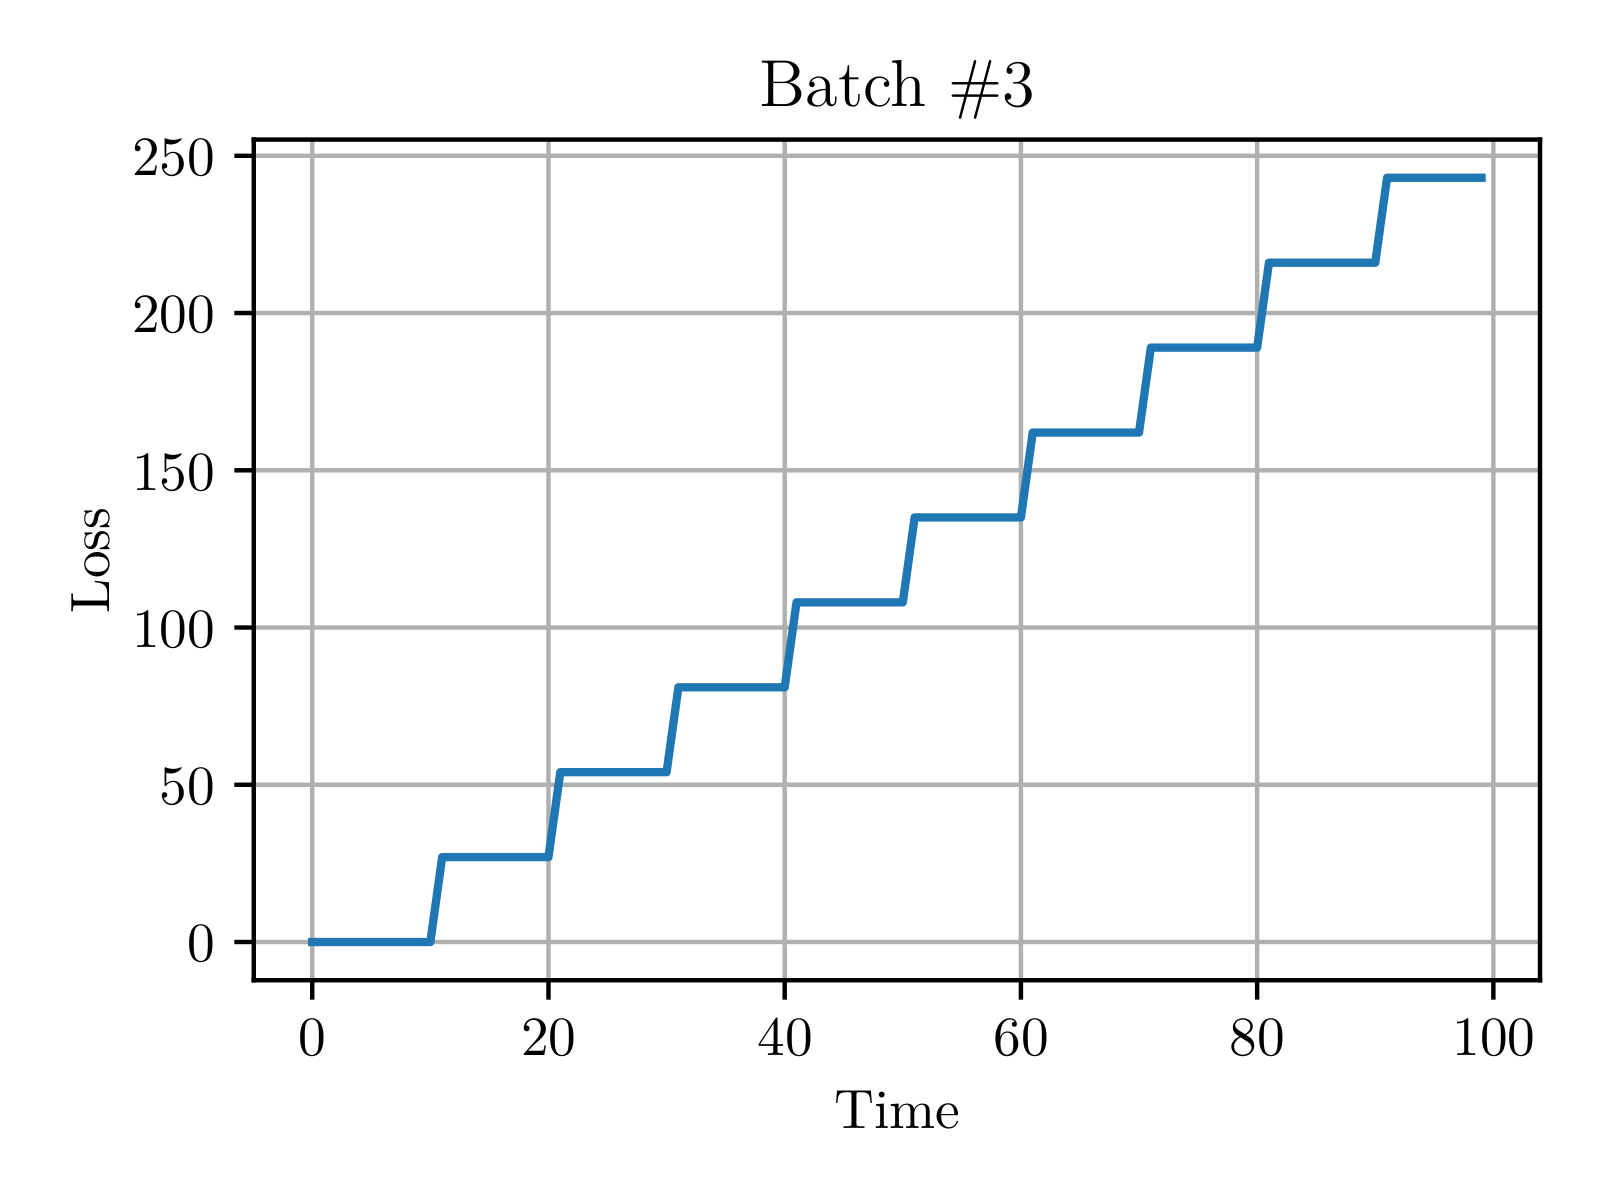
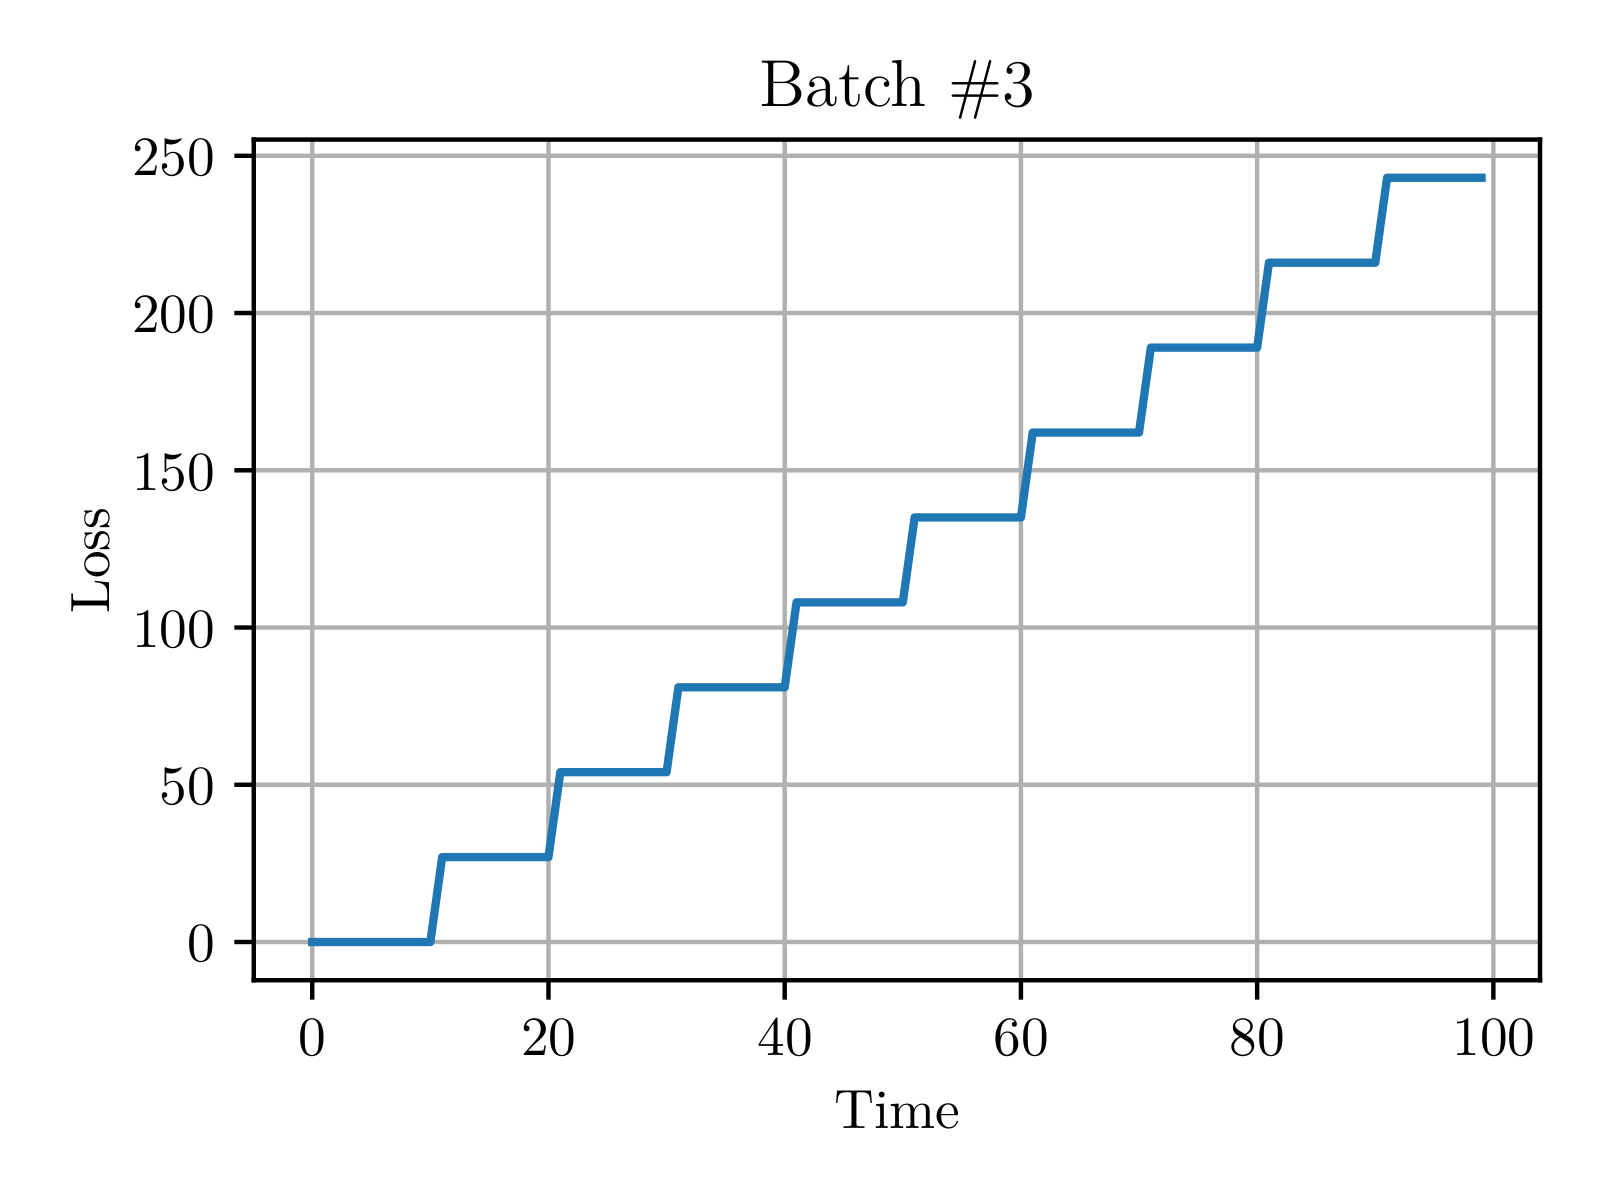
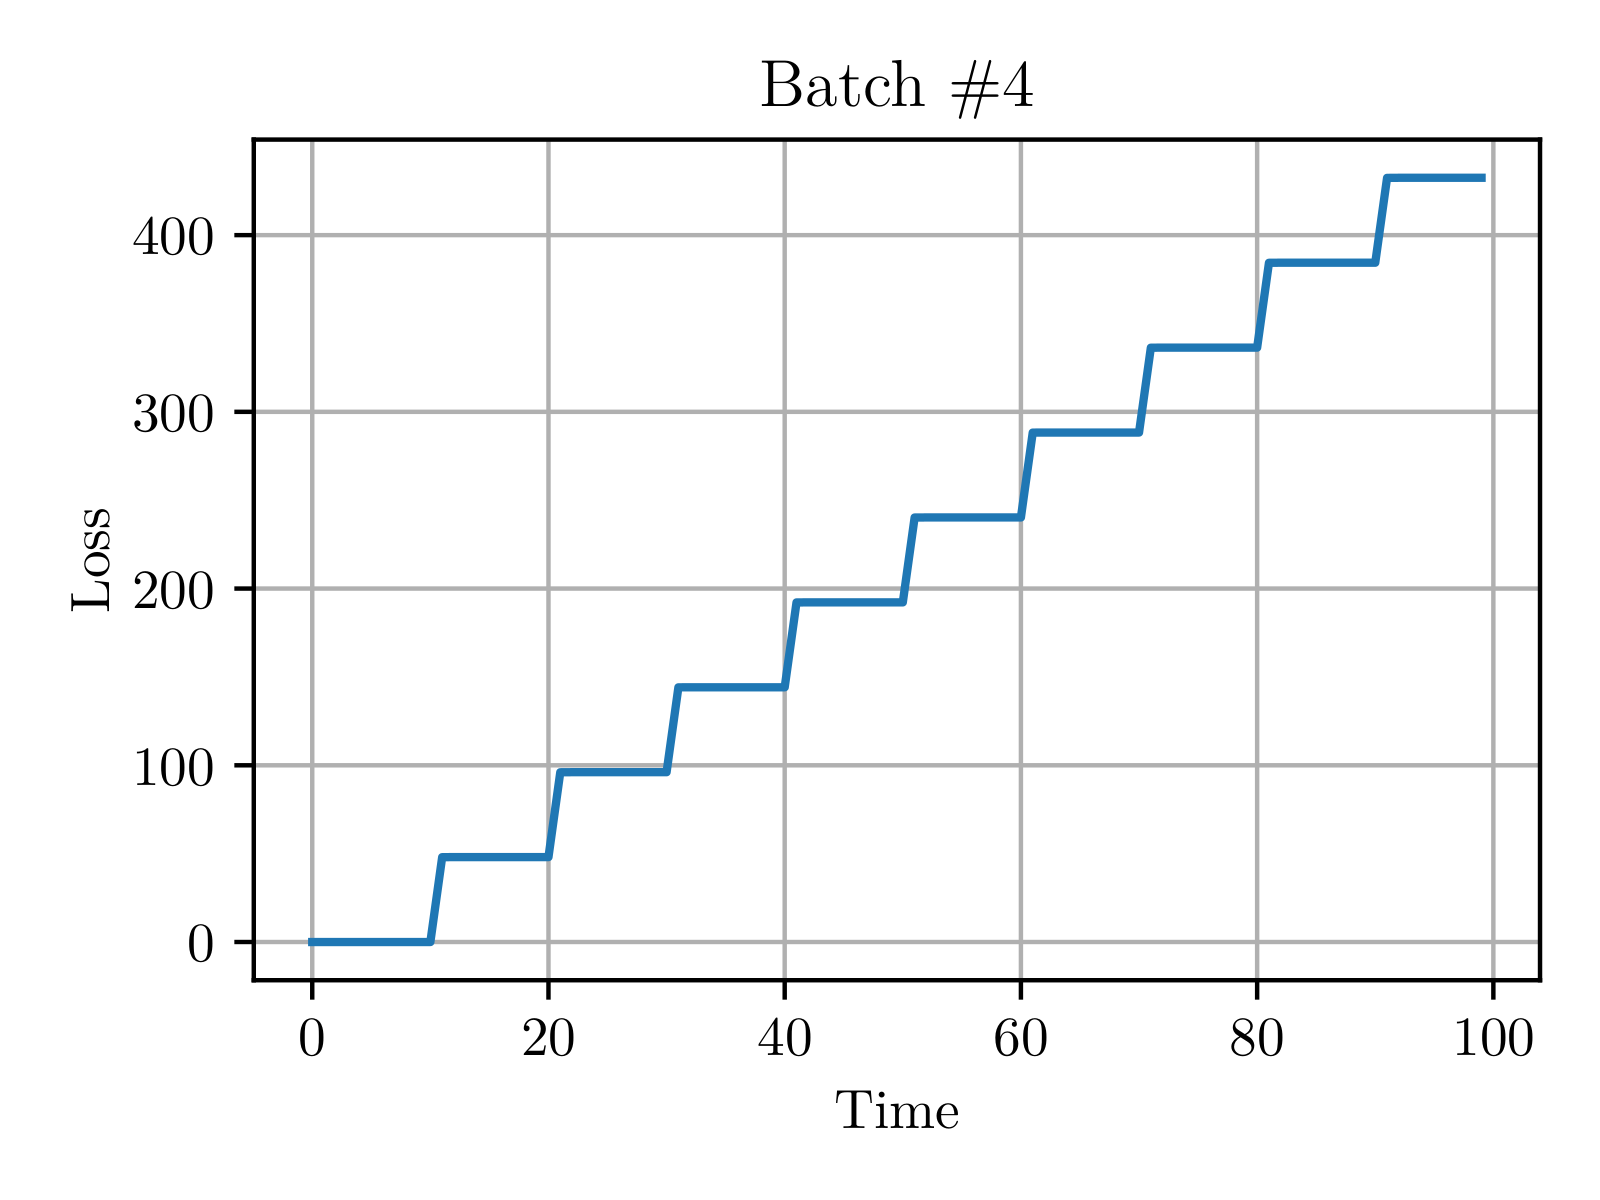
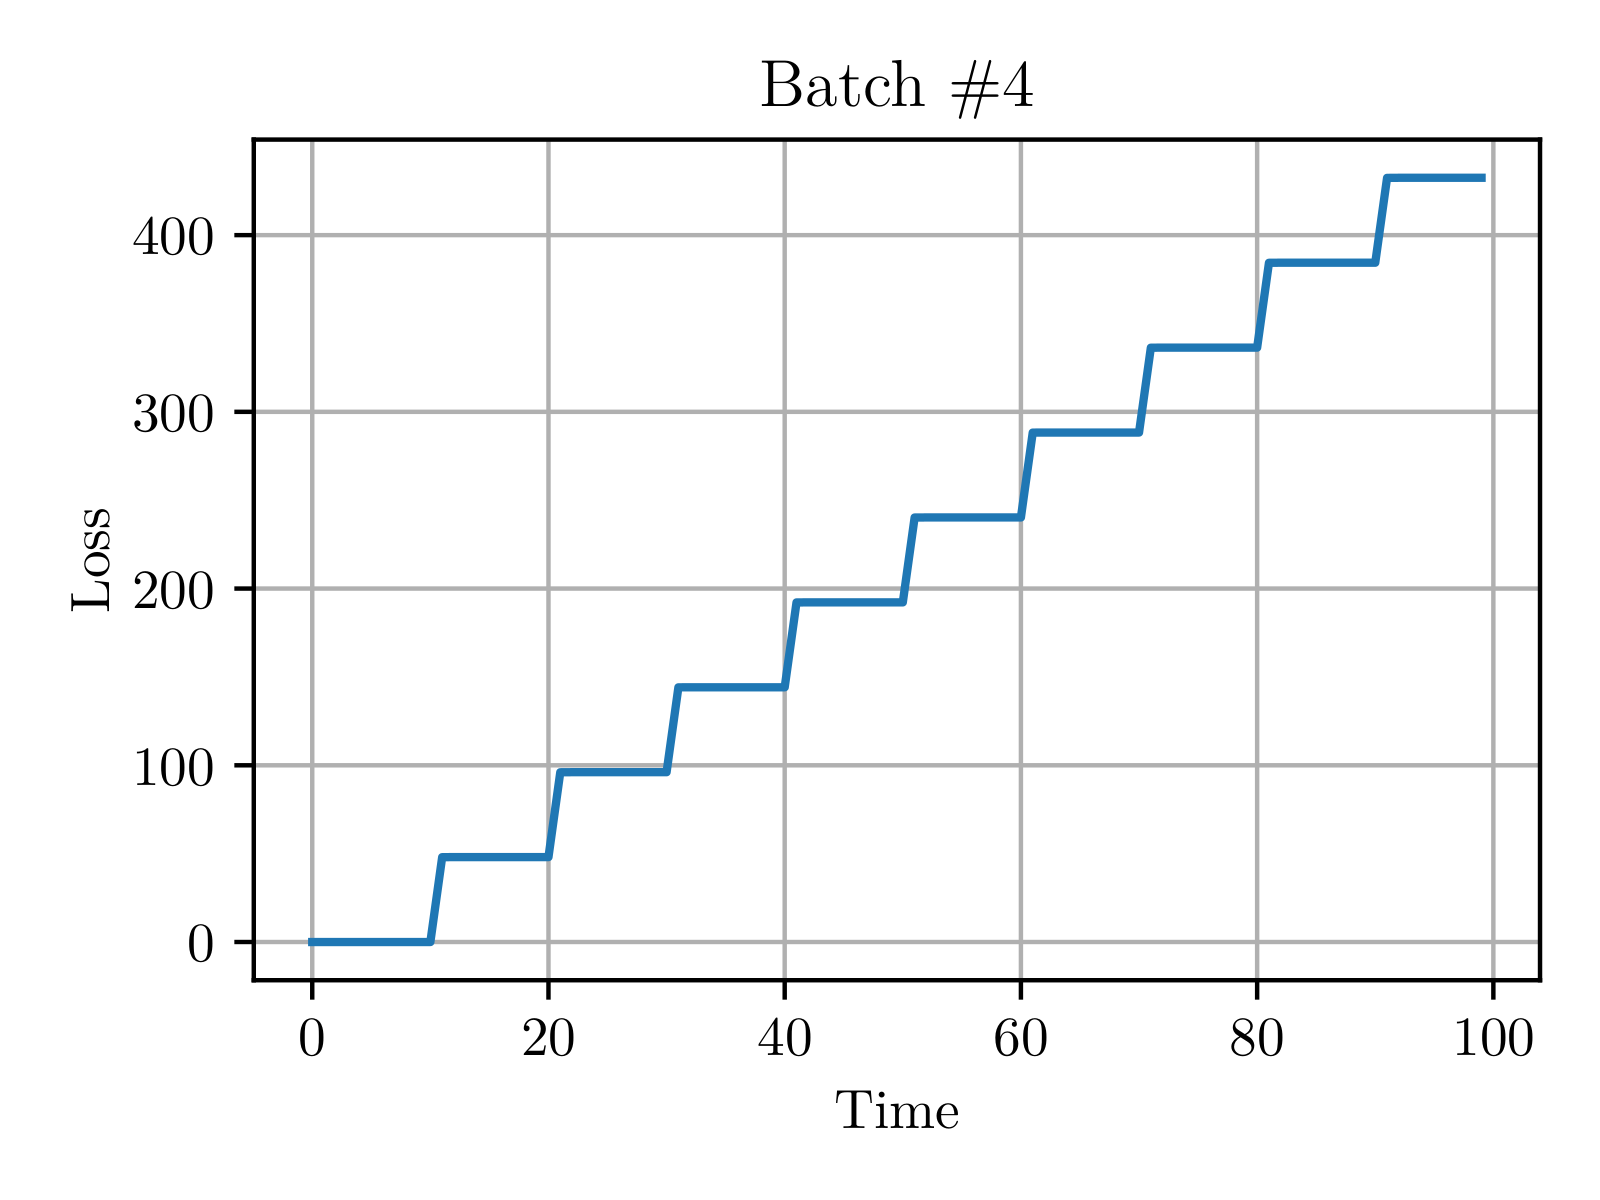

In [18]:
@ftl.with_context
def plot(loss, batch_idx, file_name):
    fig, ax = plt.subplots()
    ax.plot(loss[batch_idx])
    ax.grid()
    ax.set_xlabel('Time')
    ax.set_ylabel('Loss')
    ax.set_title(f'Batch \#{batch_idx + 1}')
    return ftl.save_fig(fig, file_name)

losses = torch.cumsum(torch.sum((X - X_pred)**2, dim=1), dim=1)
ftl.img_grid([
    plot(losses[:, :100], 0, 'loss_b1'),
    plot(losses[:, :100], 1, 'loss_b2'),
    plot(losses[:, :100], 2, 'loss_b3'),
    plot(losses[:, :100], 3, 'loss_b4'),
], n_columns=4)